In [ ]:
!rm -rf *
!git clone "https://github.com/hmda77/Ensemble-Indoor-Loc"
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Test-data.csv /content/
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Training-data.csv /content/
!rm -rf /content/Ensemble-Indoor-Loc/

# Import Packages



In [4]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder , normalize

import time
from tqdm import tqdm

from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from matplotlib import pyplot

# Metric Functions

In [5]:

# Make the confusion matrix
def confusion_plot(y_test,y_pred,title):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix {}".format(title))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    # report['Label']=[data_classes[i]  if i<5 else " " for i,x in enumerate(report.index)]
    report=report[['f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (5,4)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    # plt.title('ROC Curve for calss {0}'.format(data_classes[pos_label]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,title):
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i],pos_label= i)
      plt.plot(fpr, tpr,lw=1)
    plt.plot([0 ,1],[0 ,1],'r')
    plt.title('ROC Curve for all classes in {}'.format(title))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # plt.legend(data_classes)
    plt.show()

# Function to extract floor number, X coordinate, and Y coordinate
def extract_info(y):
    parts = y.split('-')
    floor = int(parts[0][1:])  # Extract floor number
    x_coord = float(parts[1])  # Extract X coordinate
    y_coord = float(parts[2])  # Extract Y coordinate
    return floor, x_coord, y_coord

# Calculate average error for each floor
def calculate_avg_error(y_test, y_pred, verbose = 1):
    errors = {}
    counts = {}
    for y_t, y_p in zip(y_test, y_pred):
        floor_t, x_t, y_t = extract_info(y_t)
        floor_p, x_p, y_p = extract_info(y_p)
        error = np.sqrt((x_t - x_p)**2 + (y_t - y_p)**2)
        errors.setdefault(floor_t, []).append(error)
        counts.setdefault(floor_t, 0)
        counts[floor_t] += 1

    avg_errors = {floor: sum(errors[floor]) / counts[floor] for floor in errors}

    if verbose == 1:
        print("Average errors for each floor:")
        for floor, error in avg_errors.items():
            print(f"Floor {floor}: {error}")
        print(f"Average: {sum(avg_errors.values())/3}")
    return sum(avg_errors.values())/3

# Calculate average error for each floor
def calculate_mse(y_test, y_pred, verbose = 1):
    errors = {}
    counts = {}
    for y_t, y_p in zip(y_test, y_pred):
        floor_t, x_t, y_t = extract_info(y_t)
        floor_p, x_p, y_p = extract_info(y_p)
        error = (x_t - x_p)**2 + (y_t - y_p)**2
        errors.setdefault(floor_t, []).append(error)
        counts.setdefault(floor_t, 0)
        counts[floor_t] += 1

    mse_errors = {floor: sum(errors[floor]) / counts[floor] for floor in errors}
    if verbose == 1:
        print("\nMSE for each floor:")
        for floor, error in mse_errors.items():
            print(f"Floor {floor}: {error}")
        print(f"Average: {sum(mse_errors.values())/3}")
    return sum(mse_errors.values())/3

# Calculate average error for each floor
def calculate_rmse(y_test, y_pred, verbose = 1):
    errors = {}
    counts = {}
    for y_t, y_p in zip(y_test, y_pred):
        floor_t, x_t, y_t = extract_info(y_t)
        floor_p, x_p, y_p = extract_info(y_p)
        error = (x_t - x_p)**2 + (y_t - y_p)**2
        errors.setdefault(floor_t, []).append(error)
        counts.setdefault(floor_t, 0)
        counts[floor_t] += 1

    rmse_errors = {floor: np.sqrt(sum(errors[floor]) / counts[floor]) for floor in errors}
    if verbose == 1:
        print("\nRMSE for each floor:")
        for floor, error in rmse_errors.items():
            print(f"Floor {floor}: {error}")
        print(f"Average: {sum(rmse_errors.values())/3}")
    return sum(rmse_errors.values())/3

# Dateset Proccesses

In [6]:
tr_path = "C://Users/Hamid/content/JUIndoorLoc-Training-data.csv"
ts_path = "C://Users/Hamid/content/JUIndoorLoc-Test-data.csv"

In [7]:
data_train = pd.read_csv(tr_path)
data_train.head(5)
data_test = pd.read_csv(ts_path)
data_test.head(5)

Cid  AP001  AP002  AP003  AP004  AP005  AP006  AP007  AP008  AP009  \
0  L4-33-13    -77    -58    -66    -64    -92    -66    -66    -93    -93   
1  L4-33-13    -90    -58    -78    -56    -92    -74    -74    -87    -93   
2  L4-33-13    -80    -64    -78    -56    -92    -74    -74    -87    -93   
3  L4-33-13    -72    -60    -74    -58    -93    -75    -76    -95    -93   
4  L4-33-13    -82    -56    -74    -56    -93    -71    -76    -89   -110   

   ...  AP167  AP168  AP169  AP170  AP171  AP172  Rs  Hpr  Did             Ts  
0  ...   -110   -110   -110   -110   -110   -110   0    0   D2  1489813137748  
1  ...   -110   -110   -110   -110   -110   -110   0    0   D2  1489813179138  
2  ...   -110   -110   -110   -110   -110   -110   0    0   D2  1489812948443  
3  ...   -110   -110   -110   -110   -110   -110   0    0   D2  1489812959103  
4  ...   -110   -110   -110   -110   -110   -110   0    0   D2  1489813079167  

[5 rows x 177 columns]

In [8]:
frames = [data_train, data_test]
df = pd.concat(frames)
df['Did'] = df['Did'].astype(str).str[1]
df['Did'] = pd.to_numeric(df['Did'])
df.head(5)

Cid  AP001  AP002  AP003  AP004  AP005  AP006  AP007  AP008  AP009  \
0  L4-40-1    -84    -80    -71    -58   -110    -72    -71   -110   -110   
1  L4-40-1    -84    -79    -71    -58   -110    -72    -71   -110   -110   
2  L4-40-1   -110   -110    -70    -56   -110    -69    -68   -110   -110   
3  L4-40-1   -110   -110    -70    -53   -110    -69    -68   -110   -110   
4  L4-37-2    -84    -82    -75    -65   -110    -73    -75   -110   -110   

   ...  AP167  AP168  AP169  AP170  AP171  AP172  Rs  Hpr  Did             Ts  
0  ...   -110   -110   -110   -110   -110   -110   0    1    4  1469870570949  
1  ...   -110   -110   -110   -110   -110   -110   0    1    4  1470047205646  
2  ...   -110   -110   -110   -110   -110   -110   0    1    4  1469870932338  
3  ...   -110   -110   -110   -110   -110   -110   0    1    4  1470047629440  
4  ...   -110   -110   -110   -110   -110   -110   0    1    4  1469876622694  

[5 rows x 177 columns]

In [9]:
data_combined = df.drop('Cid', axis=1).reset_index(drop=True)
data_combined = data_combined.drop('Ts', axis=1)
data_combined.head(20)

AP001  AP002  AP003  AP004  AP005  AP006  AP007  AP008  AP009  AP010  ...  \
0     -84    -80    -71    -58   -110    -72    -71   -110   -110   -110  ...   
1     -84    -79    -71    -58   -110    -72    -71   -110   -110   -110  ...   
2    -110   -110    -70    -56   -110    -69    -68   -110   -110   -110  ...   
3    -110   -110    -70    -53   -110    -69    -68   -110   -110   -110  ...   
4     -84    -82    -75    -65   -110    -73    -75   -110   -110   -110  ...   
5     -84    -81    -75    -65   -110    -73    -75   -110   -110   -110  ...   
6     -84    -80    -75    -65   -110    -73    -75   -110   -110   -110  ...   
7     -85    -80    -75    -65   -110    -73    -75   -110   -110   -110  ...   
8     -84    -80    -75    -65   -110    -73    -75   -110   -110   -110  ...   
9     -84    -80    -75    -65   -110    -73    -75   -110   -110   -110  ...   
10   -110   -110    -74    -59    -87    -77    -73    -84   -110   -110  ...   
11   -110   -110    -74    -57    -87    -77    -73    -84   -110   -110  ...   
12    -84   -110    -89    -59    -88    -73    -70    -84   -110    -87  ...   
13    -84   -110    -92    -59    -88    -73    -70    -84   -110    -87  ...   
14    -64    -66    -62    -54   -110    -56    -56   -110    -89   -110  ...   
15    -64    -66    -62    -54   -110    -56    -56   -110    -89   -110  ...   
16    -64    -63    -62    -54   -110    -56    -56   -110    -89   -110  ...   
17    -64    -62    -62    -54   -110    -56    -56   -110    -89   -110  ...   
18    -64    -65    -62    -54   -110    -56    -56   -110    -89   -110  ...   
19    -66    -64    -62    -54   -110    -56    -56   -110    -89   -110  ...   

    AP166  AP167  AP168  AP169  AP170  AP171  AP172  Rs  Hpr  Did  
0    -110   -110   -110   -110   -110   -110   -110   0    1    4  
1    -110   -110   -110   -110   -110   -110   -110   0    1    4  
2    -110   -110   -110   -110   -110   -110   -110   0    1    4  
3    -110   -110   -110   -110   -110   -110   -110   0    1    4  
4    -110   -110   -110   -110   -110   -110   -110   0    1    4  
5    -110   -110   -110   -110   -110   -110   -110   0    1    4  
6    -110   -110   -110   -110   -110   -110   -110   0    1    4  
7    -110   -110   -110   -110   -110   -110   -110   0    1    4  
8    -110   -110   -110   -110   -110   -110   -110   0    1    4  
9    -110   -110   -110   -110   -110   -110   -110   0    1    4  
10   -110   -110   -110   -110   -110   -110   -110   0    1    4  
11   -110   -110   -110   -110   -110   -110   -110   0    1    4  
12   -110   -110   -110   -110   -110   -110   -110   0    1    4  
13   -110   -110   -110   -110   -110   -110   -110   0    1    4  
14   -110   -110   -110   -110   -110   -110   -110   0    1    4  
15   -110   -110   -110   -110   -110   -110   -110   0    1    4  
16   -110   -110   -110   -110   -110   -110   -110   0    1    4  
17   -110   -110   -110   -110   -110   -110   -110   0    1    4  
18   -110   -110   -110   -110   -110   -110   -110   0    1    4  
19   -110   -110   -110   -110   -110   -110   -110   0    1    4  

[20 rows x 175 columns]

In [10]:
#make X_train from Tr
X = normalize(data_combined)
y = df.Cid

le = LabelEncoder()
le.fit(y)
le.transform(y)

X_train, Xt, y_train, yt = train_test_split(data_combined, y, test_size=0.2, shuffle=True, random_state=41)

y_train_encode =  le.transform(y_train)

y_test_encode = le.transform(yt)

X_test = Xt

# Random Forest, AdaBoost, XGBoost

## Deceision Tree 

### Depth 10

In [45]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

dt_model = RandomForestClassifier(
    n_estimators=1,
    max_depth=10,
    random_state=42,
    min_samples_split=2,
    n_jobs=-1  # Utilize all available CPU cores
)
dt_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.06367611885070801


In [46]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = dt_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.05402779579162598


In [19]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

f1-score  precision    recall    support
L3-1-13       0.000000   0.000000  0.000000     0.0000
L3-1-14       0.000000   0.000000  0.000000     0.0000
L3-1-16       0.000000   0.000000  0.000000     0.0000
L3-1-17       0.000000   0.000000  0.000000     0.0000
L3-10-11      0.000000   0.000000  0.000000     0.0000
L3-10-12      0.000000   0.000000  0.000000     0.0000
L3-10-14      0.000000   0.000000  0.000000     0.0000
L3-10-15      0.000000   0.000000  0.000000     0.0000
L3-10-16      0.000000   0.000000  0.000000     0.0000
L3-10-17      0.000000   0.000000  0.000000     0.0000
L3-10-5       0.000000   0.000000  0.000000     0.0000
L3-10-6       0.000000   0.000000  0.000000     0.0000
L3-10-8       0.000000   0.000000  0.000000     0.0000
L3-11-10      0.000000   0.000000  0.000000     0.0000
L3-11-11      0.000000   0.000000  0.000000     0.0000
L3-11-12      0.000000   0.000000  0.000000     0.0000
L3-11-13      0.000000   0.000000  0.000000     0.0000
L3-11-14      0.000000   0.000000  0.000000     0.0000
L3-11-15      0.000000   0.000000  0.000000     0.0000
L3-11-17      0.000000   0.000000  0.000000     0.0000
L3-11-5       0.000000   0.000000  0.000000     0.0000
L3-11-8       0.000000   0.000000  0.000000     0.0000
L3-11-9       0.000000   0.000000  0.000000     0.0000
L3-12-10      0.000000   0.000000  0.000000     0.0000
L3-12-11      0.000000   0.000000  0.000000     0.0000
L3-12-12      0.000000   0.000000  0.000000     0.0000
L3-12-13      0.000000   0.000000  0.000000     0.0000
L3-12-14      0.000000   0.000000  0.000000     0.0000
L3-12-16      0.000000   0.000000  0.000000     0.0000
L3-12-17      0.000000   0.000000  0.000000     0.0000
L3-12-5       0.000000   0.000000  0.000000     0.0000
L3-12-6       0.000000   0.000000  0.000000     0.0000
L3-12-8       0.000000   0.000000  0.000000     0.0000
L3-12-9       0.000000   0.000000  0.000000     0.0000
L3-13-10      0.000000   0.000000  0.000000     0.0000
L3-13-11      0.000000   0.000000  0.000000     0.0000
L3-13-12      0.000000   0.000000  0.000000     0.0000
L3-13-14      0.000000   0.000000  0.000000     0.0000
L3-13-15      0.000000   0.000000  0.000000     0.0000
L3-13-17      0.000000   0.000000  0.000000     0.0000
L3-13-7       0.000000   0.000000  0.000000     0.0000
L3-13-8       0.000000   0.000000  0.000000     0.0000
L3-13-9       0.000000   0.000000  0.000000     0.0000
L3-14-11      0.000000   0.000000  0.000000     0.0000
L3-14-12      0.000000   0.000000  0.000000     0.0000
L3-14-14      0.000000   0.000000  0.000000     0.0000
L3-14-15      0.000000   0.000000  0.000000     0.0000
L3-14-16      0.000000   0.000000  0.000000     0.0000
L3-14-5       0.000000   0.000000  0.000000     0.0000
L3-14-6       0.000000   0.000000  0.000000     0.0000
L3-14-7       0.000000   0.000000  0.000000     0.0000
L3-14-9       0.000000   0.000000  0.000000     0.0000
L3-15-10      0.000000   0.000000  0.000000     0.0000
L3-15-11      0.000000   0.000000  0.000000     0.0000
L3-15-12      0.000000   0.000000  0.000000     0.0000
L3-15-13      0.000000   0.000000  0.000000     0.0000
L3-15-14      0.000000   0.000000  0.000000     0.0000
L3-15-16      0.000000   0.000000  0.000000     0.0000
L3-15-17      0.000000   0.000000  0.000000     0.0000
L3-15-5       0.000000   0.000000  0.000000     0.0000
L3-15-6       0.000000   0.000000  0.000000     0.0000
L3-15-9       0.000000   0.000000  0.000000     0.0000
L3-16-10      0.000000   0.000000  0.000000     0.0000
L3-16-11      0.000000   0.000000  0.000000     0.0000
L3-16-12      0.000000   0.000000  0.000000     0.0000
L3-16-13      0.000000   0.000000  0.000000     0.0000
L3-16-15      0.000000   0.000000  0.000000     0.0000
L3-16-16      0.000000   0.000000  0.000000     0.0000
L3-16-17      0.000000   0.000000  0.000000     0.0000
L3-16-9       0.000000   0.000000  0.000000     0.0000
L3-17-10      0.000000   0.000000  0.000000     0.0000
L3-17-11      0.000000   0.000000  0.000000     0.0000

In [20]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 7.970890394532769
Recall: 8.219988172678889
Precision: 12.212277434572885
Accuracy: 8.219988172678889


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 9.17310487876745
Floor 5: 11.616521305688366
Floor 3: 25.95835779156055
Average: 15.58266132533879

MSE for each floor:
Floor 4: 141.36211340206185
Floor 5: 239.87917146144994
Floor 3: 706.1666666666666
Average: 362.4693171767262

RMSE for each floor:
Floor 4: 11.889580034722078
Floor 5: 15.48803316956191
Floor 3: 26.573796617470123
Average: 17.98380327391804


### Depth 50

In [39]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

dt_model = RandomForestClassifier(
    n_estimators=1,
    max_depth=50,
    random_state=42,
    min_samples_split=2,
    n_jobs=-1  # Utilize all available CPU cores
)

dt_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.27839088439941406


In [44]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = dt_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.05352449417114258


In [26]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

f1-score  precision    recall      support
L3-1-11       0.000000   0.000000  0.000000     1.000000
L3-1-12       0.000000   0.000000  0.000000     1.000000
L3-1-13       0.500000   0.500000  0.500000     2.000000
L3-1-14       0.800000   1.000000  0.666667     3.000000
L3-1-16       0.500000   0.333333  1.000000     1.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-10      0.000000   0.000000  0.000000     2.000000
L3-10-11      1.000000   1.000000  1.000000     1.000000
L3-10-12      1.000000   1.000000  1.000000     1.000000
L3-10-13      0.000000   0.000000  0.000000     2.000000
L3-10-14      0.000000   0.000000  0.000000     1.000000
L3-10-15      0.571429   0.666667  0.500000     4.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.666667   0.500000  1.000000     1.000000
L3-11-10      0.666667   0.500000  1.000000     1.000000
L3-11-11      0.000000   0.000000  0.000000     1.000000
L3-11-12      0.000000   0.000000  0.000000     1.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.666667   0.500000  1.000000     2.000000
L3-11-15      0.500000   0.500000  0.500000     2.000000
L3-11-16      0.000000   0.000000  0.000000     1.000000
L3-11-17      1.000000   1.000000  1.000000     1.000000
L3-11-5       1.000000   1.000000  1.000000     1.000000
L3-11-7       0.000000   0.000000  0.000000     1.000000
L3-11-8       0.857143   1.000000  0.750000     4.000000
L3-11-9       0.666667   0.500000  1.000000     2.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.800000   0.666667  1.000000     2.000000
L3-12-12      0.000000   0.000000  0.000000     1.000000
L3-12-13      0.000000   0.000000  0.000000     2.000000
L3-12-14      0.666667   0.500000  1.000000     1.000000
L3-12-16      0.666667   1.000000  0.500000     2.000000
L3-12-17      0.800000   0.666667  1.000000     2.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.400000   0.500000  0.333333     3.000000
L3-12-7       0.000000   0.000000  0.000000     1.000000
L3-12-8       0.857143   0.750000  1.000000     3.000000
L3-12-9       0.400000   0.333333  0.500000     2.000000
L3-13-10      0.571429   1.000000  0.400000     5.000000
L3-13-11      1.000000   1.000000  1.000000     3.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-13      0.000000   0.000000  0.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.400000   0.333333  0.500000     2.000000
L3-13-17      0.666667   0.500000  1.000000     1.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.500000   0.500000  0.500000     2.000000
L3-13-8       0.857143   1.000000  0.750000     4.000000
L3-13-9       0.888889   1.000000  0.800000     5.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     1.000000
L3-14-13      0.000000   0.000000  0.000000     4.000000
L3-14-14      0.285714   1.000000  0.166667     6.000000
L3-14-15      0.400000   1.000000  0.250000     4.000000
L3-14-16      0.000000   0.000000  0.000000     3.000000
L3-14-17      0.000000   0.000000  0.000000     1.000000
L3-14-5       1.000000   1.000000  1.000000     2.000000
L3-14-6       1.000000   1.000000  1.000000     2.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     1.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.800000   0.666667  1.000000     2.000000
L3-15-14      0.500000   1.000000  0.333333     3.000000
L3-15-15      0.000000   0.000000  0.000000     4.000000
L3-15-16      0.500000  

In [27]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 83.10280126024855
Recall: 82.49556475458309
Precision: 87.74626256972817
Accuracy: 82.49556475458309


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.7326198055273834
Floor 5: 0.8723073694495395
Floor 3: 1.5985954044128274
Average: 1.0678408597965834

MSE for each floor:
Floor 4: 6.920618556701031
Floor 5: 11.964326812428078
Floor 3: 10.669753086419753
Average: 9.851566151849621

RMSE for each floor:
Floor 4: 2.6307068549538224
Floor 5: 3.458948801648859
Floor 3: 3.266458799130911
Average: 3.1187048185778643


### Depth 100

In [29]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

dt_model = RandomForestClassifier(
    n_estimators=1,
    max_depth=100,
    random_state=42,
    min_samples_split=2,
    n_jobs=-1  # Utilize all available CPU cores
)
dt_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.28742408752441406


In [30]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = dt_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.057456016540527344


In [31]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

f1-score  precision    recall      support
L3-1-11       0.000000   0.000000  0.000000     1.000000
L3-1-12       0.000000   0.000000  0.000000     1.000000
L3-1-13       0.500000   0.500000  0.500000     2.000000
L3-1-14       0.800000   1.000000  0.666667     3.000000
L3-1-16       0.500000   0.333333  1.000000     1.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-10      0.000000   0.000000  0.000000     2.000000
L3-10-11      1.000000   1.000000  1.000000     1.000000
L3-10-12      1.000000   1.000000  1.000000     1.000000
L3-10-13      0.000000   0.000000  0.000000     2.000000
L3-10-14      0.000000   0.000000  0.000000     1.000000
L3-10-15      0.571429   0.666667  0.500000     4.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.666667   0.500000  1.000000     1.000000
L3-11-10      0.666667   0.500000  1.000000     1.000000
L3-11-11      0.000000   0.000000  0.000000     1.000000
L3-11-12      0.000000   0.000000  0.000000     1.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.666667   0.500000  1.000000     2.000000
L3-11-15      0.500000   0.500000  0.500000     2.000000
L3-11-16      0.000000   0.000000  0.000000     1.000000
L3-11-17      1.000000   1.000000  1.000000     1.000000
L3-11-5       1.000000   1.000000  1.000000     1.000000
L3-11-7       0.000000   0.000000  0.000000     1.000000
L3-11-8       0.857143   1.000000  0.750000     4.000000
L3-11-9       0.666667   0.500000  1.000000     2.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.800000   0.666667  1.000000     2.000000
L3-12-12      0.000000   0.000000  0.000000     1.000000
L3-12-13      0.000000   0.000000  0.000000     2.000000
L3-12-14      0.666667   0.500000  1.000000     1.000000
L3-12-16      0.666667   1.000000  0.500000     2.000000
L3-12-17      0.800000   0.666667  1.000000     2.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.400000   0.500000  0.333333     3.000000
L3-12-7       0.000000   0.000000  0.000000     1.000000
L3-12-8       0.857143   0.750000  1.000000     3.000000
L3-12-9       0.400000   0.333333  0.500000     2.000000
L3-13-10      0.571429   1.000000  0.400000     5.000000
L3-13-11      1.000000   1.000000  1.000000     3.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-13      0.000000   0.000000  0.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.400000   0.333333  0.500000     2.000000
L3-13-17      0.666667   0.500000  1.000000     1.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.500000   0.500000  0.500000     2.000000
L3-13-8       0.857143   1.000000  0.750000     4.000000
L3-13-9       0.888889   1.000000  0.800000     5.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     1.000000
L3-14-13      0.000000   0.000000  0.000000     4.000000
L3-14-14      0.285714   1.000000  0.166667     6.000000
L3-14-15      0.400000   1.000000  0.250000     4.000000
L3-14-16      0.000000   0.000000  0.000000     3.000000
L3-14-17      0.000000   0.000000  0.000000     1.000000
L3-14-5       1.000000   1.000000  1.000000     2.000000
L3-14-6       1.000000   1.000000  1.000000     2.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     1.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.800000   0.666667  1.000000     2.000000
L3-15-14      0.500000   1.000000  0.333333     3.000000
L3-15-15      0.000000   0.000000  0.000000     4.000000
L3-15-16      0.500000  

In [32]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 84.84749777004355
Recall: 85.0187265917603
Precision: 87.80009365757445
Accuracy: 85.0187265917603


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.5271379272847232
Floor 5: 0.6741239075683719
Floor 3: 1.5985954044128274
Average: 0.9332857464219743

MSE for each floor:
Floor 4: 4.310309278350515
Floor 5: 7.446490218642118
Floor 3: 10.669753086419753
Average: 7.475517527804129

RMSE for each floor:
Floor 4: 2.0761284349361713
Floor 5: 2.72882579485062
Floor 3: 3.266458799130911
Average: 2.690471009639234


### Depth MAX

In [34]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

dt_model = RandomForestClassifier(
    n_estimators=1,
    max_depth=176,
    random_state=42,
    min_samples_split=2,
    n_jobs=-1  # Utilize all available CPU cores
)
dt_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.2894916534423828


In [35]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = dt_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.05793881416320801


In [36]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

f1-score  precision    recall      support
L3-1-11       0.000000   0.000000  0.000000     1.000000
L3-1-12       0.000000   0.000000  0.000000     1.000000
L3-1-13       0.500000   0.500000  0.500000     2.000000
L3-1-14       0.800000   1.000000  0.666667     3.000000
L3-1-16       0.500000   0.333333  1.000000     1.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-10      0.000000   0.000000  0.000000     2.000000
L3-10-11      1.000000   1.000000  1.000000     1.000000
L3-10-12      1.000000   1.000000  1.000000     1.000000
L3-10-13      0.000000   0.000000  0.000000     2.000000
L3-10-14      0.000000   0.000000  0.000000     1.000000
L3-10-15      0.571429   0.666667  0.500000     4.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.666667   0.500000  1.000000     1.000000
L3-11-10      0.666667   0.500000  1.000000     1.000000
L3-11-11      0.000000   0.000000  0.000000     1.000000
L3-11-12      0.000000   0.000000  0.000000     1.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.666667   0.500000  1.000000     2.000000
L3-11-15      0.500000   0.500000  0.500000     2.000000
L3-11-16      0.000000   0.000000  0.000000     1.000000
L3-11-17      1.000000   1.000000  1.000000     1.000000
L3-11-5       1.000000   1.000000  1.000000     1.000000
L3-11-7       0.000000   0.000000  0.000000     1.000000
L3-11-8       0.857143   1.000000  0.750000     4.000000
L3-11-9       0.666667   0.500000  1.000000     2.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.800000   0.666667  1.000000     2.000000
L3-12-12      0.000000   0.000000  0.000000     1.000000
L3-12-13      0.000000   0.000000  0.000000     2.000000
L3-12-14      0.666667   0.500000  1.000000     1.000000
L3-12-16      0.666667   1.000000  0.500000     2.000000
L3-12-17      0.800000   0.666667  1.000000     2.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.400000   0.500000  0.333333     3.000000
L3-12-7       0.000000   0.000000  0.000000     1.000000
L3-12-8       0.857143   0.750000  1.000000     3.000000
L3-12-9       0.400000   0.333333  0.500000     2.000000
L3-13-10      0.571429   1.000000  0.400000     5.000000
L3-13-11      1.000000   1.000000  1.000000     3.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-13      0.000000   0.000000  0.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.400000   0.333333  0.500000     2.000000
L3-13-17      0.666667   0.500000  1.000000     1.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.500000   0.500000  0.500000     2.000000
L3-13-8       0.857143   1.000000  0.750000     4.000000
L3-13-9       0.888889   1.000000  0.800000     5.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     1.000000
L3-14-13      0.000000   0.000000  0.000000     4.000000
L3-14-14      0.285714   1.000000  0.166667     6.000000
L3-14-15      0.400000   1.000000  0.250000     4.000000
L3-14-16      0.000000   0.000000  0.000000     3.000000
L3-14-17      0.000000   0.000000  0.000000     1.000000
L3-14-5       1.000000   1.000000  1.000000     2.000000
L3-14-6       1.000000   1.000000  1.000000     2.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     1.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.800000   0.666667  1.000000     2.000000
L3-15-14      0.500000   1.000000  0.333333     3.000000
L3-15-15      0.000000   0.000000  0.000000     4.000000
L3-15-16      0.500000  

In [37]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 84.84749777004355
Recall: 85.0187265917603
Precision: 87.80009365757445
Accuracy: 85.0187265917603


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.5271379272847232
Floor 5: 0.6741239075683719
Floor 3: 1.5985954044128274
Average: 0.9332857464219743

MSE for each floor:
Floor 4: 4.310309278350515
Floor 5: 7.446490218642118
Floor 3: 10.669753086419753
Average: 7.475517527804129

RMSE for each floor:
Floor 4: 2.0761284349361713
Floor 5: 2.72882579485062
Floor 3: 3.266458799130911
Average: 2.690471009639234


### max_depth 1 to 176

In [59]:
import warnings
warnings.filterwarnings('ignore')
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for max_depth in tqdm(range(1, 176)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    dt_model = RandomForestClassifier(
        n_estimators=1,
        max_depth=max_depth,
        random_state=42,
        min_samples_split=2,
        n_jobs=-1  # Utilize all available CPU cores
    )
    dt_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = dt_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [01:22<00:00,  2.12it/s]


In [60]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('DT_evaluation_metrics_max_depth.csv', index=False)

In [61]:
df = pd.read_csv('DT_evaluation_metrics_max_depth.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [62]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0015) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0015) for f1 in f1_scores]


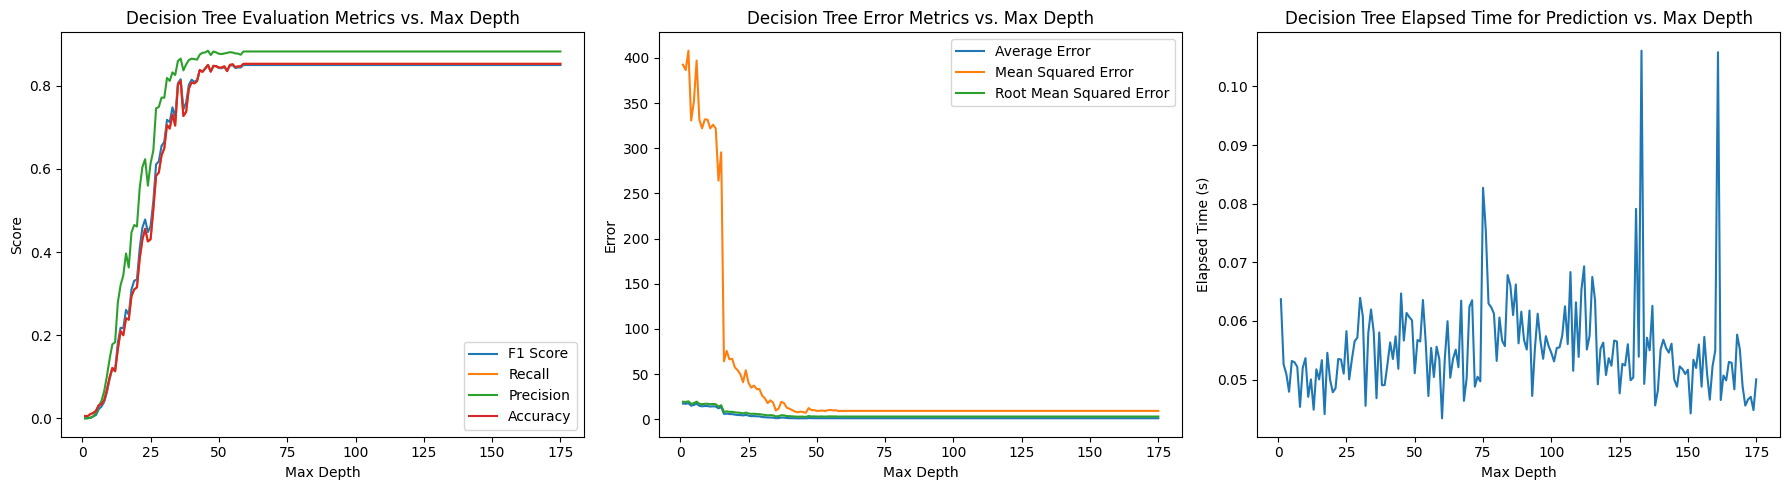

In [63]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scores, label='F1 Score')
plt.plot(range(1, 176), recall_scores, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Decision Tree Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Decision Tree Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('Decision Tree Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()



plt.show()

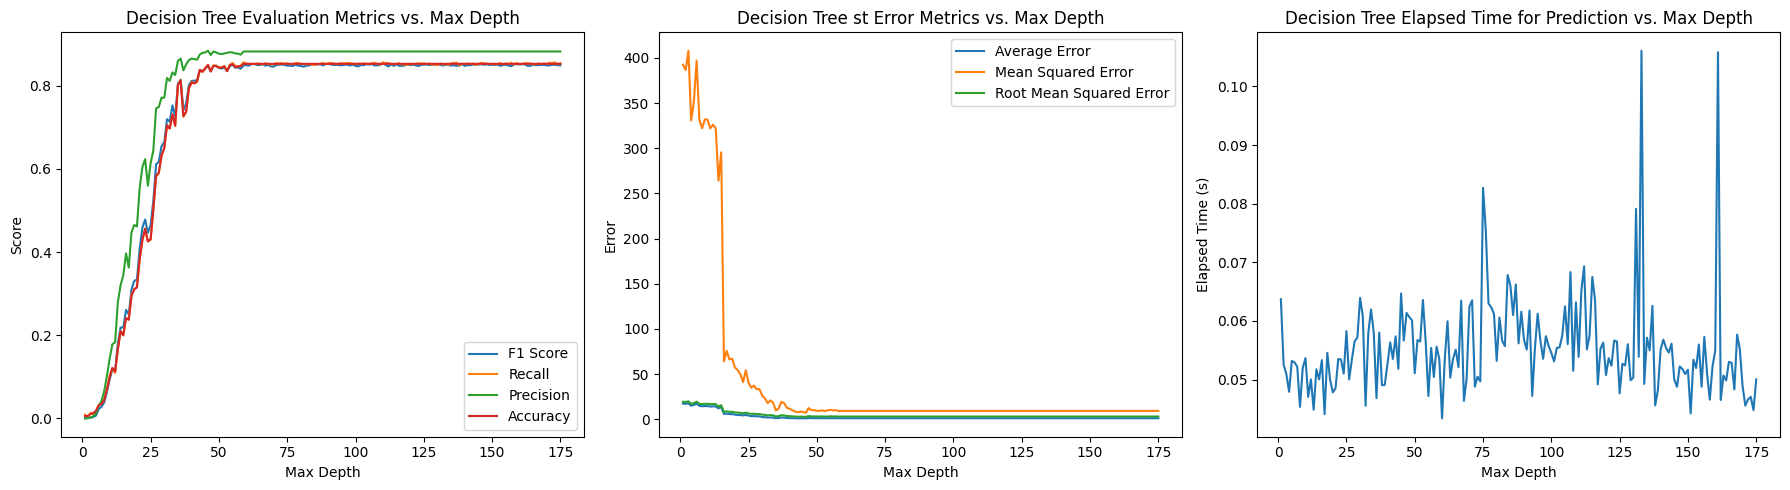

In [64]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scoresss, label='F1 Score')
plt.plot(range(1, 176), recall_scoresss, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Decision Tree Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Decision Tree st Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('Decision Tree Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()

# Save the plot as PNG
plt.savefig('DT_evaluation_metrics_max_depth.png')

# Save the plot as SVG
plt.savefig('DT_evaluation_metrics_max_depth.svg')

plt.show()

## Random Forest

### n_estimators = 10

In [61]:
n_learners = 2
max_depth = None

In [62]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

rf_model = RandomForestClassifier(
    n_estimators=n_learners,
    max_depth=None,
    random_state=42,
    min_samples_split=2,
    n_jobs=-1  # Utilize all available CPU cores
)
rf_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.32066822052001953


In [63]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = rf_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.08246970176696777


In [64]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.8538866835928106

In [65]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

f1-score  precision    recall      support
L3-1-10       0.000000   0.000000  0.000000     1.000000
L3-1-11       0.000000   0.000000  0.000000     1.000000
L3-1-12       0.000000   0.000000  0.000000     2.000000
L3-1-13       0.500000   0.500000  0.500000     2.000000
L3-1-14       0.800000   1.000000  0.666667     3.000000
L3-1-16       0.444444   0.666667  0.333333     6.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-10      0.000000   0.000000  0.000000     2.000000
L3-10-11      0.666667   1.000000  0.500000     2.000000
L3-10-12      1.000000   1.000000  1.000000     1.000000
L3-10-13      0.000000   0.000000  0.000000     2.000000
L3-10-14      0.285714   0.333333  0.250000     4.000000
L3-10-15      0.857143   1.000000  0.750000     4.000000
L3-10-16      0.800000   1.000000  0.666667     3.000000
L3-10-17      0.000000   0.000000  0.000000     2.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.400000   0.500000  0.333333     3.000000
L3-10-9       0.000000   0.000000  0.000000     1.000000
L3-11-10      0.666667   0.500000  1.000000     1.000000
L3-11-11      0.000000   0.000000  0.000000     1.000000
L3-11-12      0.400000   0.500000  0.333333     3.000000
L3-11-13      0.666667   1.000000  0.500000     2.000000
L3-11-14      0.750000   0.750000  0.750000     4.000000
L3-11-15      0.800000   1.000000  0.666667     3.000000
L3-11-17      1.000000   1.000000  1.000000     1.000000
L3-11-5       0.666667   1.000000  0.500000     2.000000
L3-11-8       0.400000   0.333333  0.500000     2.000000
L3-11-9       0.666667   0.500000  1.000000     2.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.800000   0.666667  1.000000     2.000000
L3-12-12      0.333333   0.333333  0.333333     3.000000
L3-12-13      0.000000   0.000000  0.000000     2.000000
L3-12-14      0.000000   0.000000  0.000000     0.000000
L3-12-16      0.500000   1.000000  0.333333     3.000000
L3-12-17      0.500000   0.333333  1.000000     1.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.400000   0.500000  0.333333     3.000000
L3-12-7       0.000000   0.000000  0.000000     1.000000
L3-12-8       0.857143   0.750000  1.000000     3.000000
L3-12-9       0.857143   1.000000  0.750000     4.000000
L3-13-10      0.571429   1.000000  0.400000     5.000000
L3-13-11      1.000000   1.000000  1.000000     3.000000
L3-13-12      0.666667   0.500000  1.000000     2.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.666667   0.666667  0.666667     3.000000
L3-13-16      0.000000   0.000000  0.000000     1.000000
L3-13-17      1.000000   1.000000  1.000000     2.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.500000   0.500000  0.500000     2.000000
L3-13-8       0.857143   1.000000  0.750000     4.000000
L3-13-9       0.888889   1.000000  0.800000     5.000000
L3-14-10      0.000000   0.000000  0.000000     1.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     2.000000
L3-14-14      0.500000   1.000000  0.333333     3.000000
L3-14-15      0.666667   1.000000  0.500000     2.000000
L3-14-16      0.000000   0.000000  0.000000     1.000000
L3-14-17      0.000000   0.000000  0.000000     1.000000
L3-14-5       1.000000   1.000000  1.000000     2.000000
L3-14-6       1.000000   1.000000  1.000000     2.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     4.000000
L3-15-10      0.000000   0.000000  0.000000     1.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     1.000000
L3-15-13      0.800000   0.666667  1.000000     2.000000
L3-15-14      0.333333   1.000000  0.200000     5.000000
L3-15-15      0.000000   0.000000  0.000000     2.000000
L3-15-16      0.000000  

In [66]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 85.38866835928106
Recall: 85.66922925290756
Precision: 88.26396066586875
Accuracy: 85.66922925290756


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.5271379272847232
Floor 5: 0.6741239075683719
Floor 3: 1.5985954044128274
Average: 0.9332857464219743

MSE for each floor:
Floor 4: 4.310309278350515
Floor 5: 7.446490218642118
Floor 3: 10.669753086419753
Average: 7.475517527804129

RMSE for each floor:
Floor 4: 2.0761284349361713
Floor 5: 2.72882579485062
Floor 3: 3.266458799130911
Average: 2.690471009639234


### n_estimators = 50

In [60]:
n_estimators = 50

In [251]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=None,
                                      min_samples_split=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 4.61186957359314


In [252]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = rf_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 1.1763358116149902


In [253]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

f1-score  precision    recall      support
L3-1-13       0.571429   1.000000  0.400000     5.000000
L3-1-14       1.000000   1.000000  1.000000     2.000000
L3-1-15       0.000000   0.000000  0.000000     2.000000
L3-1-16       0.500000   0.333333  1.000000     1.000000
L3-1-17       0.400000   0.250000  1.000000     1.000000
L3-10-10      0.000000   0.000000  0.000000     1.000000
L3-10-11      1.000000   1.000000  1.000000     1.000000
L3-10-12      1.000000   1.000000  1.000000     1.000000
L3-10-13      0.000000   0.000000  0.000000     2.000000
L3-10-14      0.500000   0.333333  1.000000     1.000000
L3-10-15      0.857143   1.000000  0.750000     4.000000
L3-10-16      0.800000   1.000000  0.666667     3.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.400000   0.500000  0.333333     3.000000
L3-10-9       0.000000   0.000000  0.000000     2.000000
L3-11-10      1.000000   1.000000  1.000000     2.000000
L3-11-11      1.000000   1.000000  1.000000     1.000000
L3-11-12      1.000000   1.000000  1.000000     2.000000
L3-11-13      1.000000   1.000000  1.000000     1.000000
L3-11-14      1.000000   1.000000  1.000000     4.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     1.000000
L3-11-5       0.666667   1.000000  0.500000     2.000000
L3-11-8       0.400000   0.333333  0.500000     2.000000
L3-11-9       0.666667   0.500000  1.000000     2.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      1.000000   1.000000  1.000000     3.000000
L3-12-12      0.857143   1.000000  0.750000     4.000000
L3-12-13      1.000000   1.000000  1.000000     1.000000
L3-12-14      0.666667   0.500000  1.000000     1.000000
L3-12-16      0.666667   1.000000  0.500000     2.000000
L3-12-17      0.800000   0.666667  1.000000     2.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.666667   0.500000  1.000000     1.000000
L3-12-8       1.000000   1.000000  1.000000     4.000000
L3-12-9       1.000000   1.000000  1.000000     3.000000
L3-13-10      1.000000   1.000000  1.000000     2.000000
L3-13-11      1.000000   1.000000  1.000000     3.000000
L3-13-12      0.666667   0.500000  1.000000     2.000000
L3-13-13      0.000000   0.000000  0.000000     2.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.800000   0.666667  1.000000     2.000000
L3-13-17      1.000000   1.000000  1.000000     2.000000
L3-13-7       1.000000   1.000000  1.000000     2.000000
L3-13-8       1.000000   1.000000  1.000000     3.000000
L3-13-9       1.000000   1.000000  1.000000     4.000000
L3-14-11      1.000000   1.000000  1.000000     3.000000
L3-14-12      0.333333   0.200000  1.000000     1.000000
L3-14-13      0.000000   0.000000  0.000000     4.000000
L3-14-14      1.000000   1.000000  1.000000     1.000000
L3-14-15      0.666667   1.000000  0.500000     2.000000
L3-14-16      1.000000   1.000000  1.000000     1.000000
L3-14-17      0.000000   0.000000  0.000000     2.000000
L3-14-5       1.000000   1.000000  1.000000     2.000000
L3-14-6       0.500000   0.500000  0.500000     2.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-9       1.000000   1.000000  1.000000     1.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      1.000000   1.000000  1.000000     3.000000
L3-15-12      0.000000   0.000000  0.000000     1.000000
L3-15-13      0.800000   0.666667  1.000000     2.000000
L3-15-14      1.000000   1.000000  1.000000     1.000000
L3-15-16      0.666667   1.000000  0.500000     4.000000
L3-15-17      0.500000   0.333333  1.000000     1.000000
L3-15-5       1.000000   1.000000  1.000000     1.000000
L3-15-6       0.666667   1.000000  0.500000     2.000000
L3-15-9       1.000000   1.000000  1.000000     1.000000
L3-16-10      1.000000  

In [254]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.84488520403114
Recall: 95.80130100532229
Precision: 97.19588896111665
Accuracy: 95.80130100532229


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [255]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.06318544050798892
Floor 5: 0.13666605903040663
Floor 3: 0.37784018589619744
Average: 0.19256389514486436

MSE for each floor:
Floor 4: 0.2556701030927835
Floor 5: 2.054085155350978
Floor 3: 1.0864197530864197
Average: 1.132058337176727

RMSE for each floor:
Floor 4: 0.5056383125246577
Floor 5: 1.4332079944484604
Floor 3: 1.0423146132940955
Average: 0.9937203067557379


### n_estimators = 100

In [243]:
n_estimators = 100

In [245]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=None,
                                      min_samples_split=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 10.720368146896362


In [246]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = rf_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 3.0022952556610107


In [247]:
generate_classification_report(yt, yp)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

f1-score  precision    recall      support
L3-1-13       0.333333   0.500000  0.250000     4.000000
L3-1-14       0.800000   1.000000  0.666667     3.000000
L3-1-15       0.000000   0.000000  0.000000     2.000000
L3-1-16       0.500000   0.333333  1.000000     1.000000
L3-1-17       0.400000   0.250000  1.000000     1.000000
L3-10-11      1.000000   1.000000  1.000000     1.000000
L3-10-12      1.000000   1.000000  1.000000     1.000000
L3-10-13      0.000000   0.000000  0.000000     2.000000
L3-10-14      0.500000   0.333333  1.000000     1.000000
L3-10-15      1.000000   1.000000  1.000000     3.000000
L3-10-16      0.800000   1.000000  0.666667     3.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.400000   0.500000  0.333333     3.000000
L3-10-9       0.000000   0.000000  0.000000     2.000000
L3-11-10      1.000000   1.000000  1.000000     2.000000
L3-11-11      1.000000   1.000000  1.000000     1.000000
L3-11-12      1.000000   1.000000  1.000000     2.000000
L3-11-13      1.000000   1.000000  1.000000     1.000000
L3-11-14      1.000000   1.000000  1.000000     4.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     1.000000
L3-11-5       0.666667   1.000000  0.500000     2.000000
L3-11-8       0.400000   0.333333  0.500000     2.000000
L3-11-9       0.666667   0.500000  1.000000     2.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      1.000000   1.000000  1.000000     3.000000
L3-12-12      0.750000   1.000000  0.600000     5.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-14      0.666667   0.500000  1.000000     1.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      1.000000   1.000000  1.000000     3.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.666667   0.500000  1.000000     1.000000
L3-12-8       1.000000   1.000000  1.000000     4.000000
L3-12-9       1.000000   1.000000  1.000000     3.000000
L3-13-10      1.000000   1.000000  1.000000     2.000000
L3-13-11      1.000000   1.000000  1.000000     3.000000
L3-13-12      0.666667   0.500000  1.000000     2.000000
L3-13-14      0.666667   0.500000  1.000000     1.000000
L3-13-15      1.000000   1.000000  1.000000     3.000000
L3-13-17      1.000000   1.000000  1.000000     2.000000
L3-13-7       1.000000   1.000000  1.000000     2.000000
L3-13-8       1.000000   1.000000  1.000000     3.000000
L3-13-9       1.000000   1.000000  1.000000     4.000000
L3-14-11      1.000000   1.000000  1.000000     3.000000
L3-14-12      0.333333   0.200000  1.000000     1.000000
L3-14-13      0.000000   0.000000  0.000000     4.000000
L3-14-14      1.000000   1.000000  1.000000     1.000000
L3-14-15      0.666667   1.000000  0.500000     2.000000
L3-14-16      1.000000   1.000000  1.000000     1.000000
L3-14-17      0.000000   0.000000  0.000000     2.000000
L3-14-5       1.000000   1.000000  1.000000     2.000000
L3-14-6       0.666667   0.500000  1.000000     1.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-9       1.000000   1.000000  1.000000     1.000000
L3-15-10      1.000000   1.000000  1.000000     2.000000
L3-15-11      1.000000   1.000000  1.000000     3.000000
L3-15-12      0.000000   0.000000  0.000000     1.000000
L3-15-13      0.800000   0.666667  1.000000     2.000000
L3-15-14      1.000000   1.000000  1.000000     1.000000
L3-15-16      0.666667   1.000000  0.500000     4.000000
L3-15-17      0.500000   0.333333  1.000000     1.000000
L3-15-5       1.000000   1.000000  1.000000     1.000000
L3-15-6       0.500000   1.000000  0.333333     3.000000
L3-15-9       1.000000   1.000000  1.000000     1.000000
L3-16-10      1.000000   1.000000  1.000000     2.000000
L3-16-11      1.000000   1.000000  1.000000     4.000000
L3-16-12      1.000000  

In [248]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.80988402237118
Recall: 95.76187660161641
Precision: 97.171866944191
Accuracy: 95.76187660161641


C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [159]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.09772725521501421
Floor 5: 0.16035252987883128
Floor 3: 1.5836993619849264
Average: 0.6139263823595906

MSE for each floor:
Floor 4: 0.4713917525773196
Floor 5: 1.1841196777905638
Floor 3: 10.391975308641975
Average: 4.015828913003286

RMSE for each floor:
Floor 4: 0.6865797496120313
Floor 5: 1.088172632347719
Floor 3: 3.223658683645335
Average: 1.6661370218683615


### n_estimator 1 to 100

In [72]:
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for n_learners in tqdm(range(1, 101)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=n_learners,
        max_depth=None,
        random_state=42,
        min_samples_split=2,
        n_jobs=-1  # Utilize all available CPU cores
    )
    rf_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = rf_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:07<00:00,  6.08s/it]


In [73]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('RF_evaluation_metrics_n_estimator.csv', index=False)

In [74]:
df = pd.read_csv('RF_evaluation_metrics_n_estimator.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [75]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0005) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0005) for f1 in f1_scores]


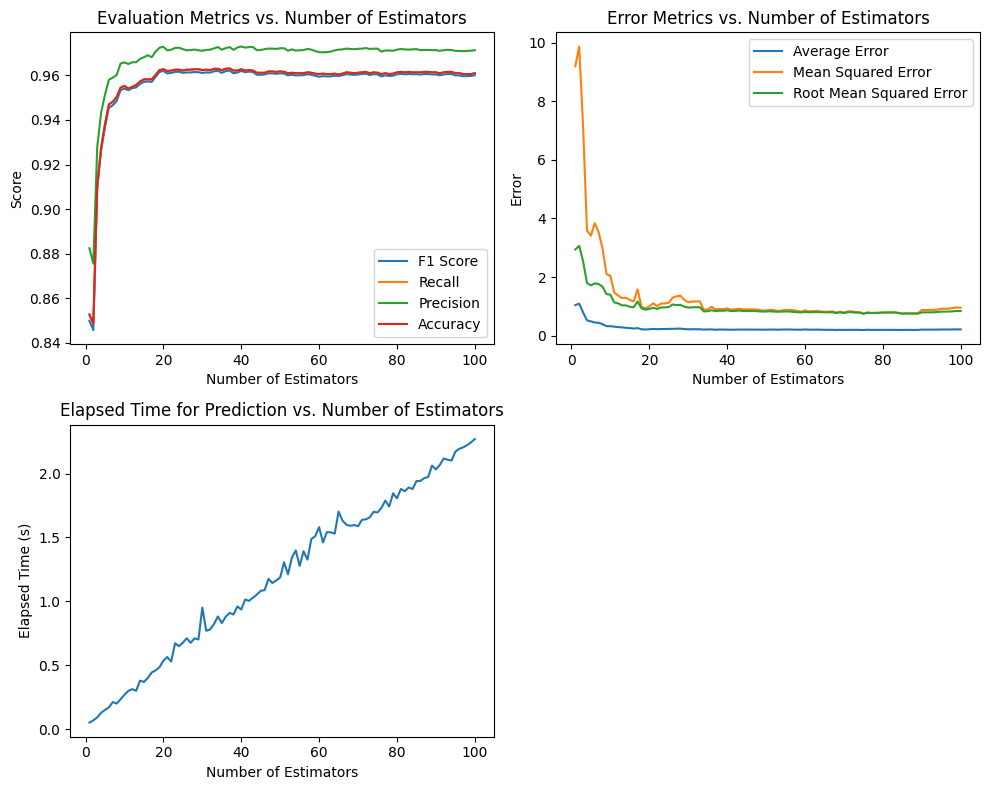

In [76]:
# Plot evaluation metrics
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, 101), f1_scores, label='F1 Score')
plt.plot(range(1, 101), recall_scores, label='Recall')
plt.plot(range(1, 101), precision_scores, label='Precision')
plt.plot(range(1, 101), accuracy_scores, label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1, 101), avg_errors, label='Average Error')
plt.plot(range(1, 101), mse_values, label='Mean Squared Error')
plt.plot(range(1, 101), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Error Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(1, 101), elapsed_times)
plt.xlabel('Number of Estimators')
plt.ylabel('Elapsed Time (s)')
plt.title('Elapsed Time for Prediction vs. Number of Estimators')

plt.tight_layout()
plt.show()

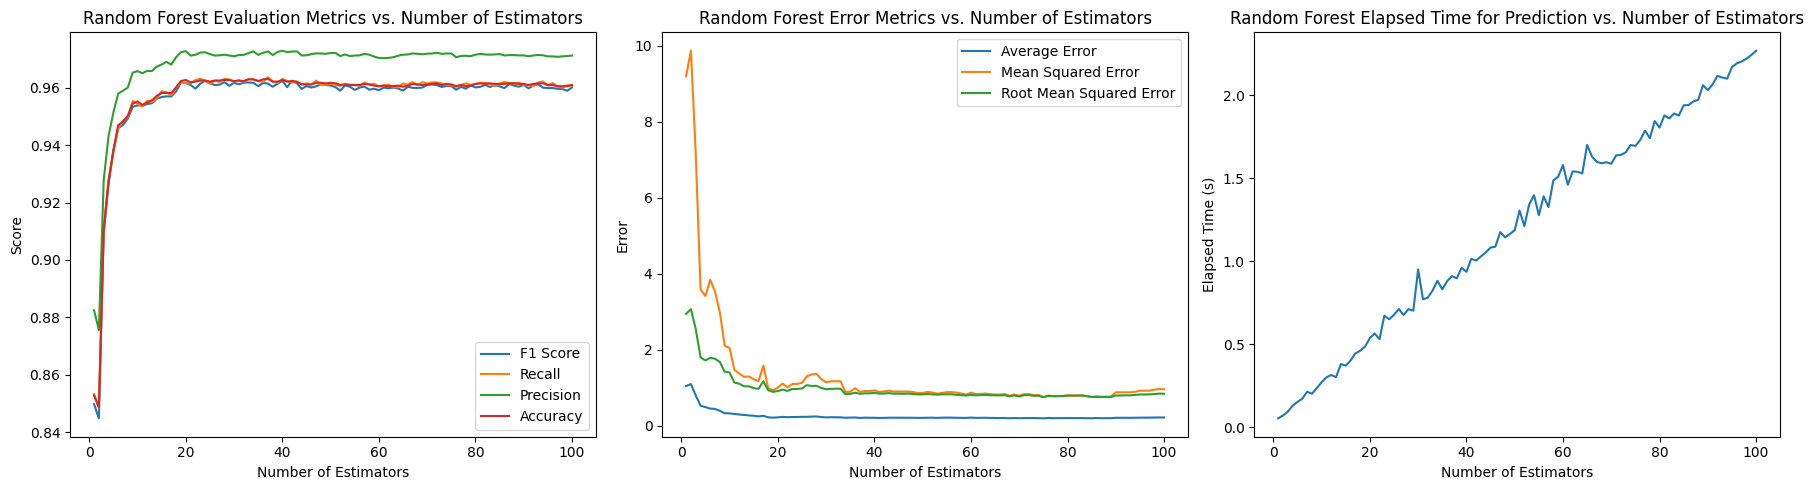

In [77]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 101), f1_scoresss, label='F1 Score')
plt.plot(range(1, 101), recall_scoresss, label='Recall')
plt.plot(range(1, 101), precision_scores, label='Precision')
plt.plot(range(1, 101), accuracy_scores, label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Random Forest Evaluation Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 101), avg_errors, label='Average Error')
plt.plot(range(1, 101), mse_values, label='Mean Squared Error')
plt.plot(range(1, 101), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Random Forest Error Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 101), elapsed_times)
plt.xlabel('Number of Estimators')
plt.ylabel('Elapsed Time (s)')
plt.title('Random Forest Elapsed Time for Prediction vs. Number of Estimators')

plt.tight_layout()
# Save the plot as PNG
plt.savefig('RF_evaluation_metrics_n_estimator.png')

# Save the plot as SVG
plt.savefig('RF_evaluation_metrics_n_estimator.svg')
plt.show()

### max_depth 1 to 176

In [78]:
import warnings
warnings.filterwarnings('ignore')
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for max_depth in tqdm(range(1, 176)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=40,
        max_depth=max_depth,
        random_state=42,
        min_samples_split=2,
        n_jobs=-1  # Utilize all available CPU cores
    )
    rf_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = rf_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [11:47<00:00,  4.04s/it]


In [79]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('RF_evaluation_metrics_max_depth.csv', index=False)

In [125]:
df = pd.read_csv('RF_evaluation_metrics_max_depth.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [126]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0015) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0015) for f1 in f1_scores]


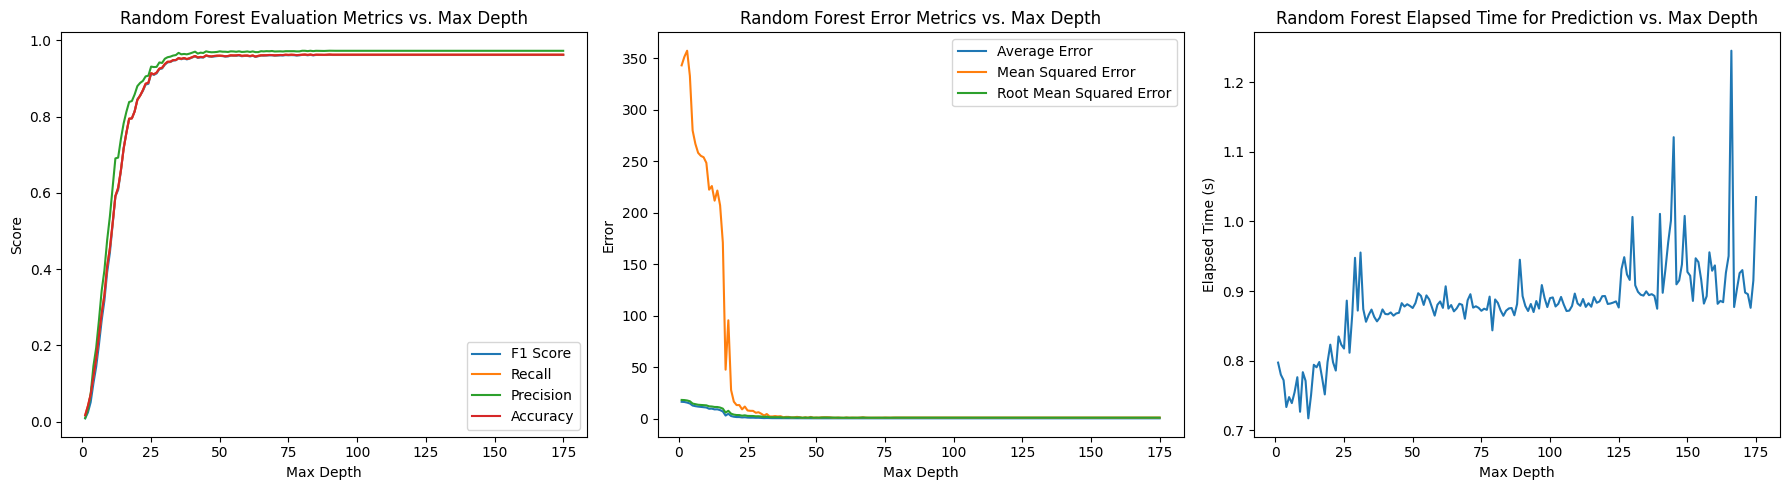

In [127]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scores, label='F1 Score')
plt.plot(range(1, 176), recall_scores, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Random Forest Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Random Forest Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('Random Forest Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()
plt.show()

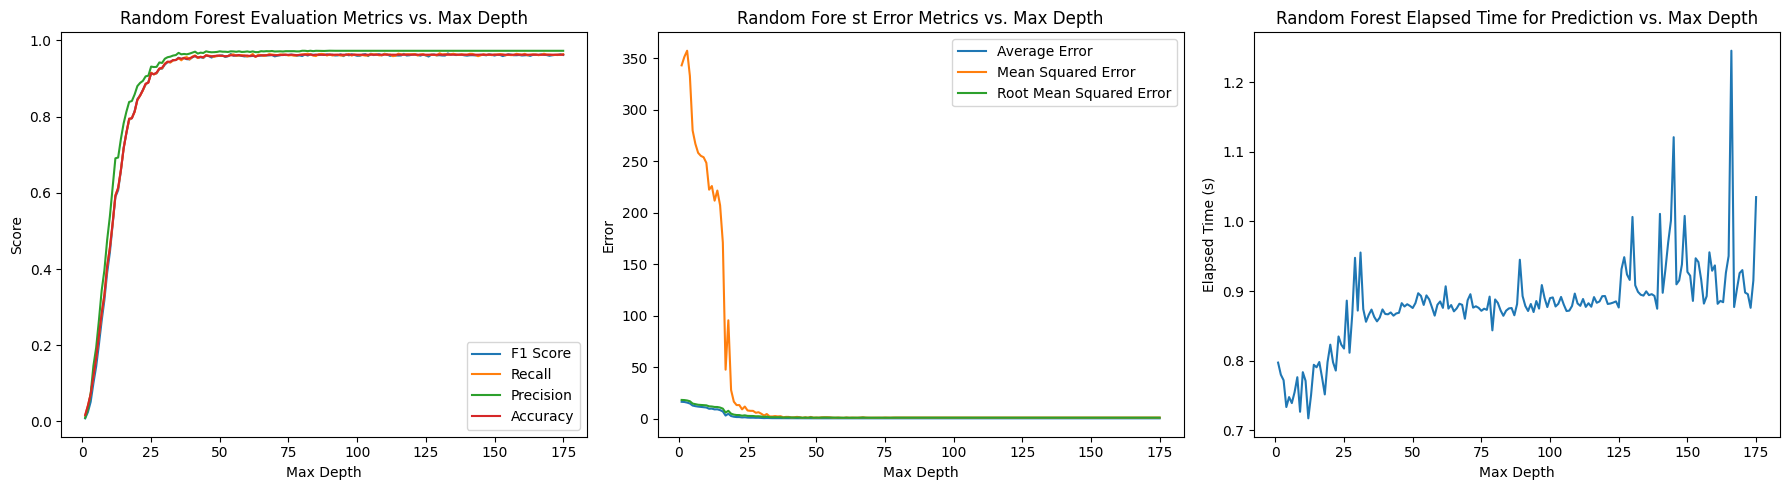

In [128]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scoresss, label='F1 Score')
plt.plot(range(1, 176), recall_scoresss, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Random Forest Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Random Fore st Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('Random Forest Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()
# Save the plot as PNG
plt.savefig('RF_evaluation_metrics_max_depth.png')

# Save the plot as SVG
plt.savefig('RF_evaluation_metrics_max_depth.svg')
plt.show()

### max depth = 10

In [133]:
max_depth = 10

In [134]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

rf_model = RandomForestClassifier(n_estimators=40, max_depth=max_depth,
                                      min_samples_split=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.6700875759124756


In [135]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = rf_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.8043489456176758


In [136]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-13       0.000000   0.000000  0.000000     0.000000
L3-1-14       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.000000   0.000000  0.000000     0.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-11      0.000000   0.000000  0.000000     0.000000
L3-10-12      0.000000   0.000000  0.000000     0.000000
L3-10-14      0.000000   0.000000  0.000000     0.000000
L3-10-15      0.000000   0.000000  0.000000     0.000000
L3-10-16      0.000000   0.000000  0.000000     0.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     0.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.000000   0.000000  0.000000     0.000000
L3-11-10      0.000000   0.000000  0.000000     0.000000
L3-11-11      0.000000   0.000000  0.000000     0.000000
L3-11-12      0.000000   0.000000  0.000000     0.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.000000   0.000000  0.000000     0.000000
L3-11-15      0.000000   0.000000  0.000000     0.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       0.000000   0.000000  0.000000     0.000000
L3-11-8       0.000000   0.000000  0.000000     0.000000
L3-11-9       0.000000   0.000000  0.000000     0.000000
L3-12-10      0.000000   0.000000  0.000000     0.000000
L3-12-11      0.000000   0.000000  0.000000     0.000000
L3-12-12      0.000000   0.000000  0.000000     0.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-14      0.000000   0.000000  0.000000     0.000000
L3-12-16      0.000000   0.000000  0.000000     0.000000
L3-12-17      0.000000   0.000000  0.000000     0.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.000000   0.000000  0.000000     0.000000
L3-12-8       0.000000   0.000000  0.000000     0.000000
L3-12-9       0.000000   0.000000  0.000000     0.000000
L3-13-10      0.000000   0.000000  0.000000     0.000000
L3-13-11      0.000000   0.000000  0.000000     0.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     0.000000
L3-13-17      0.000000   0.000000  0.000000     0.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       0.000000   0.000000  0.000000     0.000000
L3-13-9       0.000000   0.000000  0.000000     0.000000
L3-14-10      0.000000   0.000000  0.000000     1.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     0.000000
L3-14-14      0.000000   0.000000  0.000000     0.000000
L3-14-15      0.000000   0.000000  0.000000     0.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.000000   0.000000  0.000000     0.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     0.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.000000   0.000000  0.000000     0.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-16      0.000000   0.000000  0.000000     0.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-5       0.000000   0.000000  0.000000     0.000000
L3-15-6       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.000000   0.000000  0.000000     0.000000
L3-16-11      0.000000   0.000000  0.000000     0.000000
L3-16-12      0.000000   0.000000  0.000000     0.000000
L3-16-13      0.000000   0.000000  0.000000     0.000000
L3-16-15      0.000000   0.000000  0.000000     0.000000
L3-16-16      0.000000   0.000000  0.000000     0.000000
L3-16-17      0.000000  

In [137]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 50.699713389575095
Recall: 50.995466193573826
Precision: 61.46708254020481
Accuracy: 50.995466193573826


In [138]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 2.0703832036453678
Floor 5: 2.8640568856075586
Floor 3: 23.822253950718437
Average: 9.585564679990455

MSE for each floor:
Floor 4: 18.00541237113402
Floor 5: 26.879171461449943
Floor 3: 641.8148148148148
Average: 228.89979954913292

RMSE for each floor:
Floor 4: 4.243278493233036
Floor 5: 5.184512654189393
Floor 3: 25.334064316939255
Average: 11.58728515478723


11.58728515478723

### max depth = 50

In [149]:
max_depth = 50

In [150]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

rf_model = RandomForestClassifier(n_estimators=40, max_depth=max_depth,
                                      min_samples_split=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 2.9915544986724854


In [151]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = rf_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.8648912906646729


In [142]:
generate_classification_report(yt, yp)

f1-score  precision    recall     support
L3-1-13       0.400000   0.500000  0.333333     3.00000
L3-1-14       0.800000   1.000000  0.666667     3.00000
L3-1-15       0.000000   0.000000  0.000000     2.00000
L3-1-16       0.400000   0.333333  0.500000     2.00000
L3-1-17       0.400000   0.250000  1.000000     1.00000
L3-10-11      1.000000   1.000000  1.000000     1.00000
L3-10-12      1.000000   1.000000  1.000000     1.00000
L3-10-13      0.000000   0.000000  0.000000     2.00000
L3-10-14      0.500000   0.333333  1.000000     1.00000
L3-10-15      1.000000   1.000000  1.000000     3.00000
L3-10-16      0.800000   1.000000  0.666667     3.00000
L3-10-17      0.000000   0.000000  0.000000     0.00000
L3-10-5       0.000000   0.000000  0.000000     1.00000
L3-10-6       1.000000   1.000000  1.000000     1.00000
L3-10-8       0.400000   0.500000  0.333333     3.00000
L3-10-9       0.000000   0.000000  0.000000     2.00000
L3-11-10      1.000000   1.000000  1.000000     2.00000
L3-11-11      1.000000   1.000000  1.000000     1.00000
L3-11-12      1.000000   1.000000  1.000000     2.00000
L3-11-13      1.000000   1.000000  1.000000     1.00000
L3-11-14      1.000000   1.000000  1.000000     4.00000
L3-11-15      1.000000   1.000000  1.000000     2.00000
L3-11-17      1.000000   1.000000  1.000000     1.00000
L3-11-5       0.666667   1.000000  0.500000     2.00000
L3-11-8       0.400000   0.333333  0.500000     2.00000
L3-11-9       0.666667   0.500000  1.000000     2.00000
L3-12-10      1.000000   1.000000  1.000000     1.00000
L3-12-11      1.000000   1.000000  1.000000     3.00000
L3-12-12      0.857143   1.000000  0.750000     4.00000
L3-12-13      0.000000   0.000000  0.000000     0.00000
L3-12-14      1.000000   1.000000  1.000000     2.00000
L3-12-16      1.000000   1.000000  1.000000     1.00000
L3-12-17      1.000000   1.000000  1.000000     3.00000
L3-12-5       0.000000   0.000000  0.000000     0.00000
L3-12-6       1.000000   1.000000  1.000000     2.00000
L3-12-8       1.000000   1.000000  1.000000     4.00000
L3-12-9       1.000000   1.000000  1.000000     3.00000
L3-13-10      1.000000   1.000000  1.000000     2.00000
L3-13-11      1.000000   1.000000  1.000000     3.00000
L3-13-12      0.666667   0.500000  1.000000     2.00000
L3-13-14      0.666667   0.500000  1.000000     1.00000
L3-13-15      0.800000   0.666667  1.000000     2.00000
L3-13-17      1.000000   1.000000  1.000000     2.00000
L3-13-7       1.000000   1.000000  1.000000     2.00000
L3-13-8       1.000000   1.000000  1.000000     3.00000
L3-13-9       1.000000   1.000000  1.000000     4.00000
L3-14-11      1.000000   1.000000  1.000000     3.00000
L3-14-12      0.333333   0.200000  1.000000     1.00000
L3-14-13      0.000000   0.000000  0.000000     4.00000
L3-14-14      1.000000   1.000000  1.000000     1.00000
L3-14-15      0.500000   1.000000  0.333333     3.00000
L3-14-16      1.000000   1.000000  1.000000     1.00000
L3-14-17      0.000000   0.000000  0.000000     2.00000
L3-14-5       1.000000   1.000000  1.000000     2.00000
L3-14-6       0.666667   0.500000  1.000000     1.00000
L3-14-7       1.000000   1.000000  1.000000     1.00000
L3-14-9       1.000000   1.000000  1.000000     1.00000
L3-15-10      0.000000   0.000000  0.000000     0.00000
L3-15-11      0.857143   1.000000  0.750000     4.00000
L3-15-12      0.000000   0.000000  0.000000     1.00000
L3-15-13      0.500000   0.333333  1.000000     1.00000
L3-15-14      1.000000   1.000000  1.000000     1.00000
L3-15-16      0.666667   1.000000  0.500000     4.00000
L3-15-17      0.500000   0.333333  1.000000     1.00000
L3-15-5       1.000000   1.000000  1.000000     1.00000
L3-15-6       0.666667   1.000000  0.500000     2.00000
L3-15-9       1.000000   1.000000  1.000000     1.00000
L3-16-10      1.000000   1.000000  1.000000     2.00000
L3-16-11      0.750000   0.750000  0.750000     4.00000
L3-16-12      0.800000   1.000000  0.666667     3.00000
L3-16-13      1.000000   1.000000  1.0

In [143]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.68606168675193
Recall: 95.6830277942046
Precision: 97.0447711606789
Accuracy: 95.6830277942046


In [144]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.0724853309040678
Floor 5: 0.1528571676088637
Floor 3: 0.4152061224761886
Average: 0.21351620699637333

MSE for each floor:
Floor 4: 0.37010309278350517
Floor 5: 2.507479861910242
Floor 3: 1.4197530864197532
Average: 1.4324453470378333

RMSE for each floor:
Floor 4: 0.6083609888737979
Floor 5: 1.5835024035063041
Floor 3: 1.191533921640401
Average: 1.127799104673501


1.127799104673501

### max depth = 100

In [145]:
max_depth = 100

In [152]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

rf_model = RandomForestClassifier(n_estimators=40, max_depth=max_depth,
                                      min_samples_split=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 2.9619922637939453


In [153]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = rf_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.8797104358673096


In [154]:
generate_classification_report(yt, yp)

f1-score  precision    recall     support
L3-1-13       0.400000   0.500000  0.333333     3.00000
L3-1-14       0.800000   1.000000  0.666667     3.00000
L3-1-15       0.000000   0.000000  0.000000     2.00000
L3-1-16       0.400000   0.333333  0.500000     2.00000
L3-1-17       0.400000   0.250000  1.000000     1.00000
L3-10-11      1.000000   1.000000  1.000000     1.00000
L3-10-12      1.000000   1.000000  1.000000     1.00000
L3-10-13      0.000000   0.000000  0.000000     2.00000
L3-10-14      0.500000   0.333333  1.000000     1.00000
L3-10-15      1.000000   1.000000  1.000000     3.00000
L3-10-16      0.800000   1.000000  0.666667     3.00000
L3-10-17      0.000000   0.000000  0.000000     0.00000
L3-10-5       0.000000   0.000000  0.000000     1.00000
L3-10-6       1.000000   1.000000  1.000000     1.00000
L3-10-8       0.400000   0.500000  0.333333     3.00000
L3-10-9       0.000000   0.000000  0.000000     2.00000
L3-11-10      1.000000   1.000000  1.000000     2.00000
L3-11-11      1.000000   1.000000  1.000000     1.00000
L3-11-12      1.000000   1.000000  1.000000     2.00000
L3-11-13      1.000000   1.000000  1.000000     1.00000
L3-11-14      1.000000   1.000000  1.000000     4.00000
L3-11-15      1.000000   1.000000  1.000000     2.00000
L3-11-17      1.000000   1.000000  1.000000     1.00000
L3-11-5       0.666667   1.000000  0.500000     2.00000
L3-11-8       0.400000   0.333333  0.500000     2.00000
L3-11-9       0.666667   0.500000  1.000000     2.00000
L3-12-10      1.000000   1.000000  1.000000     1.00000
L3-12-11      1.000000   1.000000  1.000000     3.00000
L3-12-12      0.857143   1.000000  0.750000     4.00000
L3-12-13      0.000000   0.000000  0.000000     0.00000
L3-12-14      1.000000   1.000000  1.000000     2.00000
L3-12-16      1.000000   1.000000  1.000000     1.00000
L3-12-17      1.000000   1.000000  1.000000     3.00000
L3-12-5       0.000000   0.000000  0.000000     0.00000
L3-12-6       1.000000   1.000000  1.000000     2.00000
L3-12-8       1.000000   1.000000  1.000000     4.00000
L3-12-9       1.000000   1.000000  1.000000     3.00000
L3-13-10      1.000000   1.000000  1.000000     2.00000
L3-13-11      1.000000   1.000000  1.000000     3.00000
L3-13-12      0.666667   0.500000  1.000000     2.00000
L3-13-14      0.666667   0.500000  1.000000     1.00000
L3-13-15      0.800000   0.666667  1.000000     2.00000
L3-13-17      1.000000   1.000000  1.000000     2.00000
L3-13-7       1.000000   1.000000  1.000000     2.00000
L3-13-8       1.000000   1.000000  1.000000     3.00000
L3-13-9       1.000000   1.000000  1.000000     4.00000
L3-14-11      1.000000   1.000000  1.000000     3.00000
L3-14-12      0.333333   0.200000  1.000000     1.00000
L3-14-13      0.000000   0.000000  0.000000     4.00000
L3-14-14      1.000000   1.000000  1.000000     1.00000
L3-14-15      0.500000   1.000000  0.333333     3.00000
L3-14-16      1.000000   1.000000  1.000000     1.00000
L3-14-17      0.000000   0.000000  0.000000     2.00000
L3-14-5       1.000000   1.000000  1.000000     2.00000
L3-14-6       0.666667   0.500000  1.000000     1.00000
L3-14-7       1.000000   1.000000  1.000000     1.00000
L3-14-9       1.000000   1.000000  1.000000     1.00000
L3-15-10      0.000000   0.000000  0.000000     0.00000
L3-15-11      0.857143   1.000000  0.750000     4.00000
L3-15-12      0.000000   0.000000  0.000000     1.00000
L3-15-13      0.500000   0.333333  1.000000     1.00000
L3-15-14      1.000000   1.000000  1.000000     1.00000
L3-15-16      0.666667   1.000000  0.500000     4.00000
L3-15-17      0.500000   0.333333  1.000000     1.00000
L3-15-5       1.000000   1.000000  1.000000     1.00000
L3-15-6       0.666667   1.000000  0.500000     2.00000
L3-15-9       1.000000   1.000000  1.000000     1.00000
L3-16-10      1.000000   1.000000  1.000000     2.00000
L3-16-11      0.750000   0.750000  0.750000     4.00000
L3-16-12      0.800000   1.000000  0.666667     3.00000
L3-16-13      1.000000   1.000000  1.0

In [155]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.68606168675193
Recall: 95.6830277942046
Precision: 97.0447711606789
Accuracy: 95.6830277942046


In [156]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 0.0724853309040678
Floor 5: 0.1528571676088637
Floor 3: 0.4152061224761886
Average: 0.21351620699637333

MSE for each floor:
Floor 4: 0.37010309278350517
Floor 5: 2.507479861910242
Floor 3: 1.4197530864197532
Average: 1.4324453470378333

RMSE for each floor:
Floor 4: 0.6083609888737979
Floor 5: 1.5835024035063041
Floor 3: 1.191533921640401
Average: 1.127799104673501


1.127799104673501

## AdaBoost

### n_estimators = 10

In [192]:
n_learners = 10
max_depth = None

In [202]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

# Create RandomForest model with specified hyperparameters
base_estimator = DecisionTreeClassifier(max_depth=10, random_state=42)
ada_model = AdaBoostClassifier(
    n_estimators=n_learners,
    estimator=base_estimator,
    algorithm='SAMME',
    random_state=42,
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 4.737597465515137


In [203]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.498687744140625


In [204]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.3040811228588042

In [205]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-13       0.000000   0.000000  0.000000     0.000000
L3-1-14       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.000000   0.000000  0.000000     0.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-11      0.000000   0.000000  0.000000     0.000000
L3-10-12      0.000000   0.000000  0.000000     0.000000
L3-10-14      0.000000   0.000000  0.000000     0.000000
L3-10-15      0.000000   0.000000  0.000000     0.000000
L3-10-16      0.000000   0.000000  0.000000     0.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     0.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.000000   0.000000  0.000000     0.000000
L3-11-10      0.000000   0.000000  0.000000     0.000000
L3-11-11      0.000000   0.000000  0.000000     0.000000
L3-11-12      0.000000   0.000000  0.000000     0.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.000000   0.000000  0.000000     0.000000
L3-11-15      0.000000   0.000000  0.000000     0.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       0.000000   0.000000  0.000000     0.000000
L3-11-8       0.000000   0.000000  0.000000     0.000000
L3-11-9       0.000000   0.000000  0.000000     0.000000
L3-12-10      0.000000   0.000000  0.000000     0.000000
L3-12-11      0.000000   0.000000  0.000000     0.000000
L3-12-12      0.000000   0.000000  0.000000     0.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-14      0.000000   0.000000  0.000000     0.000000
L3-12-16      0.000000   0.000000  0.000000     0.000000
L3-12-17      0.000000   0.000000  0.000000     0.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.000000   0.000000  0.000000     0.000000
L3-12-8       0.000000   0.000000  0.000000     0.000000
L3-12-9       0.000000   0.000000  0.000000     0.000000
L3-13-10      0.000000   0.000000  0.000000     0.000000
L3-13-11      0.000000   0.000000  0.000000     0.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     0.000000
L3-13-17      0.000000   0.000000  0.000000     0.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       0.000000   0.000000  0.000000     0.000000
L3-13-9       0.000000   0.000000  0.000000     0.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     0.000000
L3-14-14      0.000000   0.000000  0.000000     0.000000
L3-14-15      0.000000   0.000000  0.000000     0.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.000000   0.000000  0.000000     0.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     0.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.000000   0.000000  0.000000     0.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-16      0.000000   0.000000  0.000000     0.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-5       0.000000   0.000000  0.000000     0.000000
L3-15-6       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.000000   0.000000  0.000000     0.000000
L3-16-11      0.000000   0.000000  0.000000     0.000000
L3-16-12      0.000000   0.000000  0.000000     0.000000
L3-16-13      0.000000   0.000000  0.000000     0.000000
L3-16-15      0.000000   0.000000  0.000000     0.000000
L3-16-16      0.000000   0.000000  0.000000     0.000000
L3-16-17      0.000000   0.000000  0.000000     0.000000
L3-16-9       0.000000  

In [189]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 7.33639816466999
Recall: 7.845456337472896
Precision: 11.392680708466477
Accuracy: 7.845456337472896


In [190]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 6.363776024918202
Floor 5: 10.28816929368279
Floor 3: 18.881707129417617
Average: 11.844550816006205

MSE for each floor:
Floor 4: 72.51649484536082
Floor 5: 150.59493670886076
Floor 3: 391.58641975308643
Average: 204.89928376910268

RMSE for each floor:
Floor 4: 8.515661738547442
Floor 5: 12.271712867764661
Floor 3: 19.78854263843314
Average: 13.525305748248414


13.525305748248414

### n_estimators = 50

In [19]:
n_learners = 50
max_depth = None

In [20]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

# Create RandomForest model with specified hyperparameters
base_estimator = DecisionTreeClassifier(max_depth=50, random_state=42)
ada_model = AdaBoostClassifier(
    n_estimators=n_learners,
    estimator=base_estimator,
    algorithm='SAMME',
    random_state=42,
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 131.11895060539246


In [21]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 2.5607521533966064


In [22]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.9555149157703882

In [23]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       1.000000   1.000000  1.000000     4.000000
L3-1-11       0.857143   1.000000  0.750000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       1.000000   1.000000  1.000000     4.000000
L3-1-15       1.000000   1.000000  1.000000     3.000000
L3-1-16       1.000000   1.000000  1.000000     1.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      0.666667   0.500000  1.000000     1.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.666667   0.500000  1.000000     1.000000
L3-10-15      0.500000   1.000000  0.333333     3.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-17      0.000000   0.000000  0.000000     2.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.666667   1.000000  0.500000     2.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      1.000000   1.000000  1.000000     3.000000
L3-11-14      0.000000   0.000000  0.000000     1.000000
L3-11-15      0.400000   0.500000  0.333333     3.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       1.000000   1.000000  1.000000     2.000000
L3-11-8       0.500000   0.500000  0.500000     2.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      0.666667   1.000000  0.500000     2.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       1.000000   1.000000  1.000000     1.000000
L3-12-6       1.000000   1.000000  1.000000     2.000000
L3-12-8       0.333333   0.250000  0.500000     2.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.800000   1.000000  0.666667     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     2.000000
L3-13-16      0.800000   0.666667  1.000000     2.000000
L3-13-17      0.857143   1.000000  0.750000     4.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-7       1.000000   1.000000  1.000000     1.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       0.600000   1.000000  0.428571     7.000000
L3-14-10      1.000000   1.000000  1.000000     1.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      1.000000   1.000000  1.000000     3.000000
L3-14-15      0.000000   0.000000  0.000000     2.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.666667   0.500000  1.000000     1.000000
L3-14-6       0.666667   1.000000  0.500000     4.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-8       0.500000   1.000000  0.333333     3.000000
L3-14-9       0.800000   0.666667  1.000000     4.000000
L3-15-10      0.500000   0.333333  1.000000     1.000000
L3-15-11      1.000000   1.000000  1.000000     2.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-15      0.000000   0.000000  0.000000     4.000000
L3-15-16      0.000000   0.000000  0.000000     1.000000
L3-15-17      0.500000   0.333333  1.000000     1.000000
L3-15-6       1.000000   1.000000  1.000000     1.000000
L3-15-7       0.500000   1.000000  0.333333     3.000000
L3-15-8       0.000000  

In [24]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.55149157703882
Recall: 95.70273999605756
Precision: 96.79444572555157
Accuracy: 95.70273999605756


In [25]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.17203019341269168
Floor 4: 0.05158434819792231
Floor 3: 0.8846892361785179
Average: 0.36943459259637734

MSE for each floor:
Floor 5: 1.0332187857961055
Floor 4: 0.19974358974358974
Floor 3: 5.556666666666667
Average: 2.263209680735454

RMSE for each floor:
Floor 5: 1.016473701477862
Floor 4: 0.4469268281761453
Floor 3: 2.3572582944316194
Average: 1.2735529413618756


1.2735529413618756

### n_estimator = 100

In [26]:
n_learners = 100
max_depth = None

In [27]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

# Create RandomForest model with specified hyperparameters
base_estimator = DecisionTreeClassifier(max_depth=50, random_state=42)
ada_model = AdaBoostClassifier(
    n_estimators=n_learners,
    estimator=base_estimator,
    algorithm='SAMME',
    random_state=42,
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 270.98716473579407


In [28]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 5.139864206314087


In [29]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.9548918963388845

In [30]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       1.000000   1.000000  1.000000     4.000000
L3-1-11       0.857143   1.000000  0.750000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       1.000000   1.000000  1.000000     4.000000
L3-1-15       1.000000   1.000000  1.000000     3.000000
L3-1-16       1.000000   1.000000  1.000000     1.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      0.666667   0.500000  1.000000     1.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.666667   0.500000  1.000000     1.000000
L3-10-15      0.500000   1.000000  0.333333     3.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-17      0.000000   0.000000  0.000000     2.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.666667   1.000000  0.500000     2.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      1.000000   1.000000  1.000000     3.000000
L3-11-14      0.000000   0.000000  0.000000     1.000000
L3-11-15      0.400000   0.500000  0.333333     3.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       1.000000   1.000000  1.000000     2.000000
L3-11-8       0.500000   0.500000  0.500000     2.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      0.666667   1.000000  0.500000     2.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       1.000000   1.000000  1.000000     1.000000
L3-12-6       1.000000   1.000000  1.000000     2.000000
L3-12-8       0.333333   0.250000  0.500000     2.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.800000   1.000000  0.666667     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     2.000000
L3-13-16      0.800000   0.666667  1.000000     2.000000
L3-13-17      0.857143   1.000000  0.750000     4.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-7       1.000000   1.000000  1.000000     1.000000
L3-13-8       0.666667   0.500000  1.000000     1.000000
L3-13-9       0.666667   1.000000  0.500000     6.000000
L3-14-10      1.000000   1.000000  1.000000     1.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      0.666667   1.000000  0.500000     2.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      1.000000   1.000000  1.000000     3.000000
L3-14-15      0.000000   0.000000  0.000000     2.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.666667   0.500000  1.000000     1.000000
L3-14-6       0.666667   1.000000  0.500000     4.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-8       0.400000   1.000000  0.250000     4.000000
L3-14-9       0.800000   0.666667  1.000000     4.000000
L3-15-10      0.285714   0.333333  0.250000     4.000000
L3-15-11      1.000000   1.000000  1.000000     2.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-15      0.000000   0.000000  0.000000     4.000000
L3-15-16      0.000000   0.000000  0.000000     1.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-6       1.000000   1.000000  1.000000     1.000000
L3-15-7       0.500000   1.000000  0.333333     3.000000
L3-15-8       0.000000  

In [31]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.48918963388844
Recall: 95.64360339049873
Precision: 96.68144018345778
Accuracy: 95.64360339049873


In [32]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.13280805008969315
Floor 4: 0.06155116212014965
Floor 3: 0.9144473916396477
Average: 0.3696022012831635

MSE for each floor:
Floor 5: 0.5097365406643757
Floor 4: 0.5182051282051282
Floor 3: 5.66
Average: 2.229313889623168

RMSE for each floor:
Floor 5: 0.7139583605956132
Floor 4: 0.7198646596445253
Floor 3: 2.3790754506740637
Average: 1.2709661569714008


1.2709661569714008

### n_estimator 1 to 100

In [210]:
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for n_learners in tqdm(range(1, 101)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    base_estimator = DecisionTreeClassifier(max_depth=50, random_state=42)
    ada_model = AdaBoostClassifier(
        n_estimators=n_learners,
        estimator=base_estimator,
        algorithm='SAMME',
        random_state=42,
    )
    ada_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = ada_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:36:19<00:00, 129.79s/it]


In [220]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('ADA_evaluation_metrics_n_estimator.csv', index=False)

In [52]:
df = pd.read_csv('ADA_evaluation_metrics_n_estimator.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [53]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0005) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0005) for f1 in f1_scores]


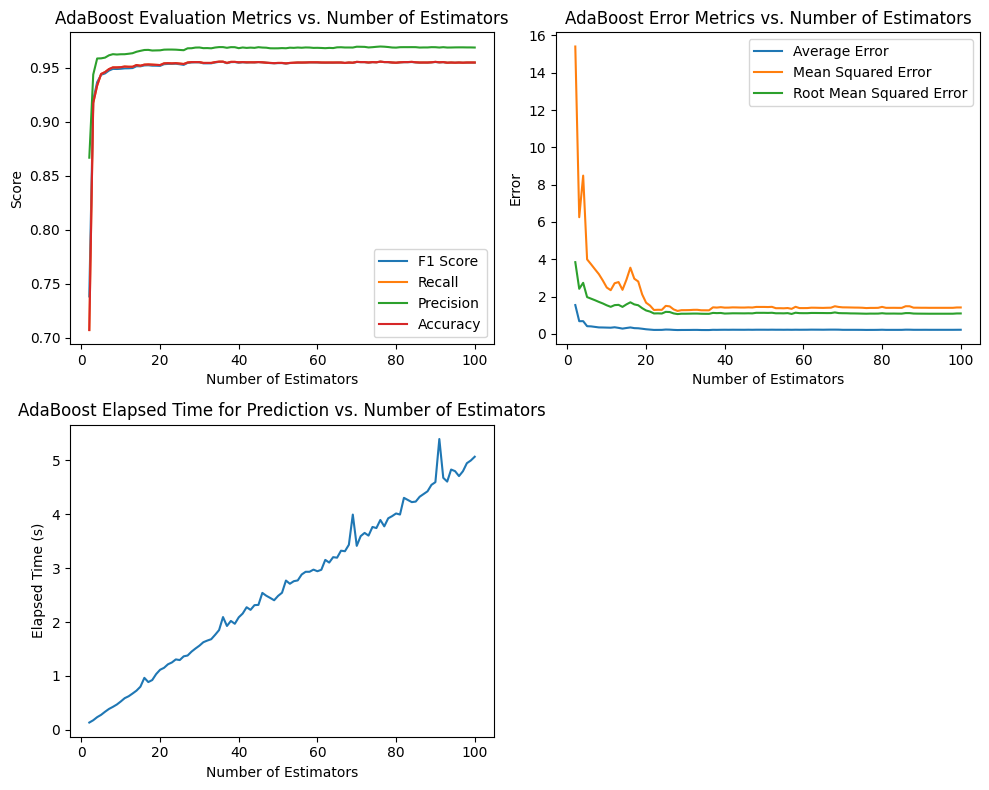

In [215]:
# Plot evaluation metrics
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(range(2, 101), f1_scores[1:], label='F1 Score')
plt.plot(range(2, 101), recall_scores[1:], label='Recall')
plt.plot(range(2, 101), precision_scores[1:], label='Precision')
plt.plot(range(2, 101), accuracy_scores[1:], label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('AdaBoost Evaluation Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(2, 101), avg_errors[1:], label='Average Error')
plt.plot(range(2, 101), mse_values[1:], label='Mean Squared Error')
plt.plot(range(2, 101), rmse_values[1:], label='Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('AdaBoost Error Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(2, 101), elapsed_times[1:])
plt.xlabel('Number of Estimators')
plt.ylabel('Elapsed Time (s)')
plt.title('AdaBoost Elapsed Time for Prediction vs. Number of Estimators')

plt.tight_layout()
plt.show()

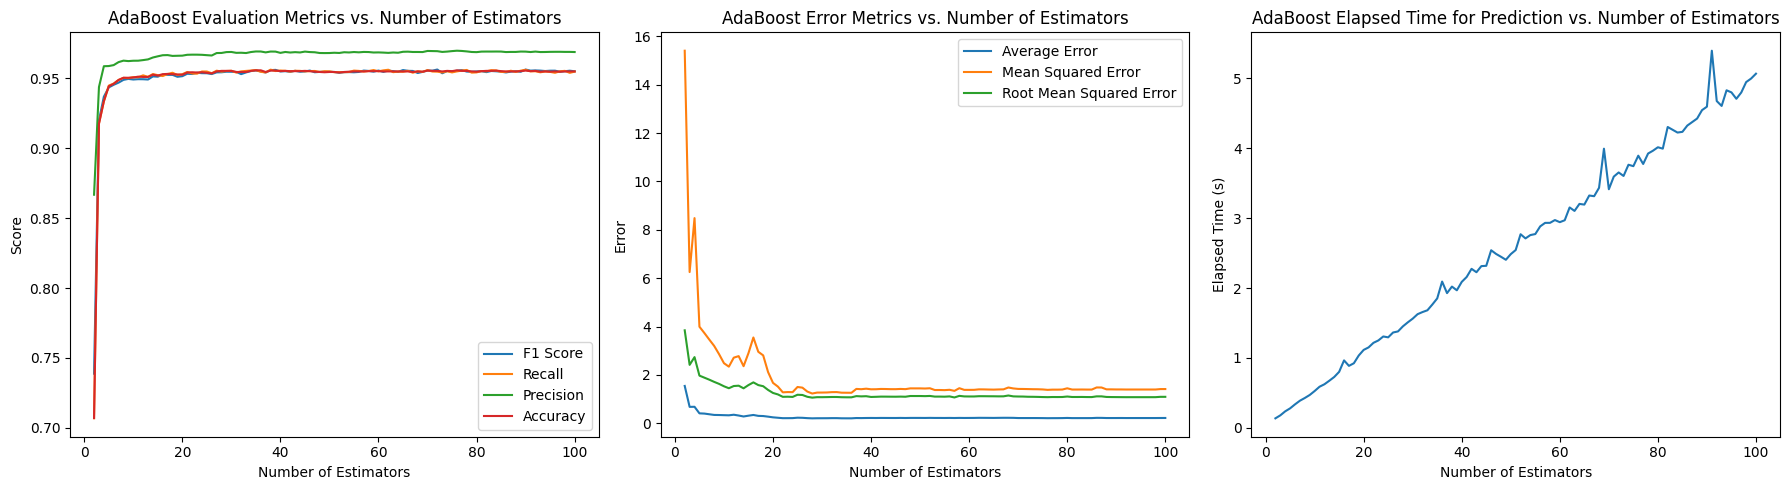

In [54]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(2, 101), f1_scoresss[1:], label='F1 Score')
plt.plot(range(2, 101), recall_scoresss[1:], label='Recall')
plt.plot(range(2, 101), precision_scores[1:], label='Precision')
plt.plot(range(2, 101), accuracy_scores[1:], label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('AdaBoost Evaluation Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(2, 101), avg_errors[1:], label='Average Error')
plt.plot(range(2, 101), mse_values[1:], label='Mean Squared Error')
plt.plot(range(2, 101), rmse_values[1:], label='Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('AdaBoost Error Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(2, 101), elapsed_times[1:])
plt.xlabel('Number of Estimators')
plt.ylabel('Elapsed Time (s)')
plt.title('AdaBoost Elapsed Time for Prediction vs. Number of Estimators')

plt.tight_layout()
# Save the plot as PNG
plt.savefig('ADA_evaluation_metrics_n_estimator.png')

# Save the plot as SVG
plt.savefig('ADA_evaluation_metrics_n_estimator.svg')
plt.show()


### max_depth 1 to 176

In [34]:
import warnings
warnings.filterwarnings('ignore')
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for max_depth in tqdm(range(1, 176)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    ada_model = AdaBoostClassifier(
        n_estimators=40,
        estimator=base_estimator,
        algorithm='SAMME',
        random_state=42,
    )
    ada_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = ada_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [4:27:08<00:00, 91.59s/it]


In [39]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('Ada_evaluation_metrics_max_depth.csv', index=False)

In [46]:
df = pd.read_csv('Ada_evaluation_metrics_max_depth.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [47]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0015) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0015) for f1 in f1_scores]


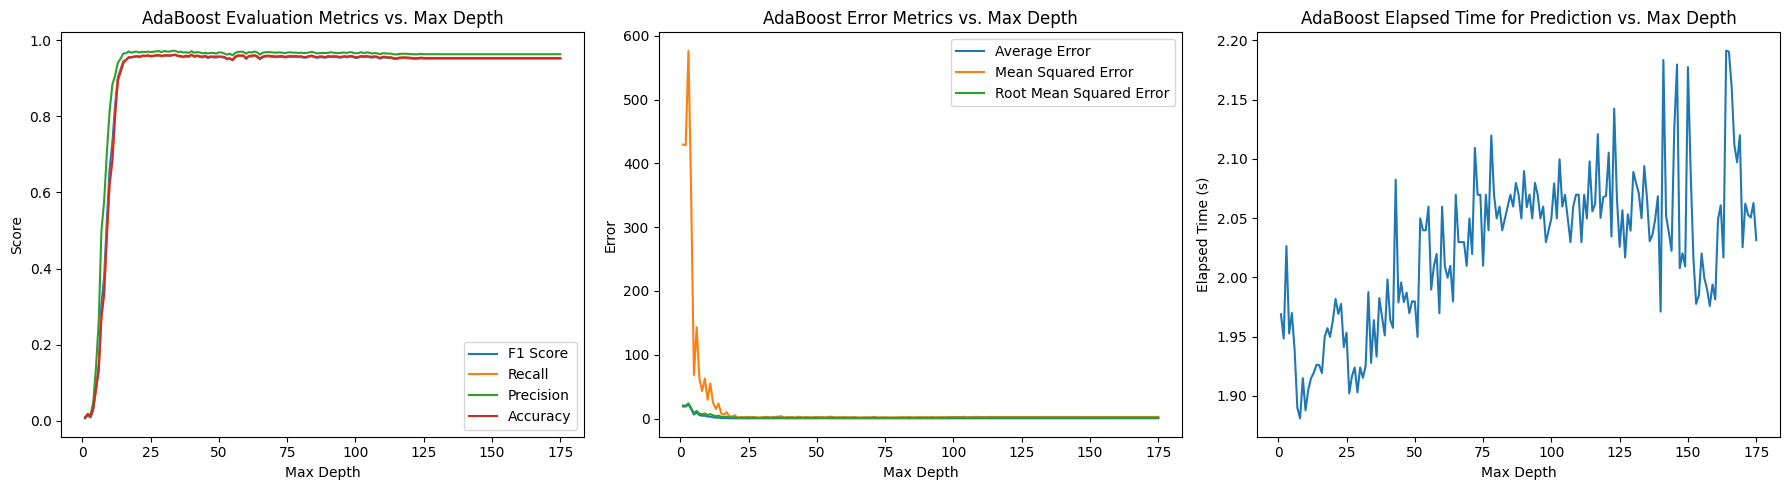

In [48]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scores, label='F1 Score')
plt.plot(range(1, 176), recall_scores, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('AdaBoost Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('AdaBoost Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('AdaBoost Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()



plt.show()

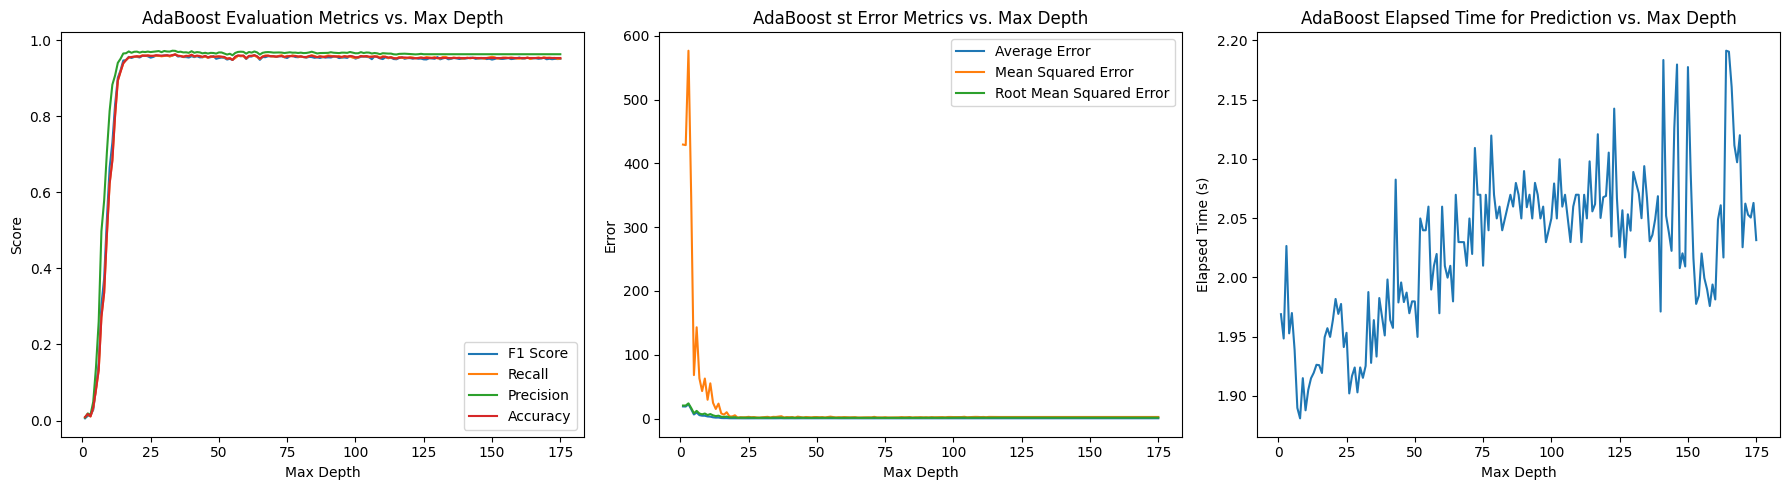

In [49]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scoresss, label='F1 Score')
plt.plot(range(1, 176), recall_scoresss, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('AdaBoost Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('AdaBoost st Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('AdaBoost Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()

# Save the plot as PNG
plt.savefig('Ada_evaluation_metrics_max_depth.png')

# Save the plot as SVG
plt.savefig('Ada_evaluation_metrics_max_depth.svg')

plt.show()

### max depth = 10

In [133]:
max_depth = 10

In [134]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
ada_model = AdaBoostClassifier(
    n_estimators=40,
    estimator=base_estimator,
    algorithm='SAMME',
    random_state=42,
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.6700875759124756


In [135]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.8043489456176758


In [136]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-13       0.000000   0.000000  0.000000     0.000000
L3-1-14       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.000000   0.000000  0.000000     0.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-11      0.000000   0.000000  0.000000     0.000000
L3-10-12      0.000000   0.000000  0.000000     0.000000
L3-10-14      0.000000   0.000000  0.000000     0.000000
L3-10-15      0.000000   0.000000  0.000000     0.000000
L3-10-16      0.000000   0.000000  0.000000     0.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     0.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.000000   0.000000  0.000000     0.000000
L3-11-10      0.000000   0.000000  0.000000     0.000000
L3-11-11      0.000000   0.000000  0.000000     0.000000
L3-11-12      0.000000   0.000000  0.000000     0.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.000000   0.000000  0.000000     0.000000
L3-11-15      0.000000   0.000000  0.000000     0.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       0.000000   0.000000  0.000000     0.000000
L3-11-8       0.000000   0.000000  0.000000     0.000000
L3-11-9       0.000000   0.000000  0.000000     0.000000
L3-12-10      0.000000   0.000000  0.000000     0.000000
L3-12-11      0.000000   0.000000  0.000000     0.000000
L3-12-12      0.000000   0.000000  0.000000     0.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-14      0.000000   0.000000  0.000000     0.000000
L3-12-16      0.000000   0.000000  0.000000     0.000000
L3-12-17      0.000000   0.000000  0.000000     0.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.000000   0.000000  0.000000     0.000000
L3-12-8       0.000000   0.000000  0.000000     0.000000
L3-12-9       0.000000   0.000000  0.000000     0.000000
L3-13-10      0.000000   0.000000  0.000000     0.000000
L3-13-11      0.000000   0.000000  0.000000     0.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     0.000000
L3-13-17      0.000000   0.000000  0.000000     0.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       0.000000   0.000000  0.000000     0.000000
L3-13-9       0.000000   0.000000  0.000000     0.000000
L3-14-10      0.000000   0.000000  0.000000     1.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     0.000000
L3-14-14      0.000000   0.000000  0.000000     0.000000
L3-14-15      0.000000   0.000000  0.000000     0.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.000000   0.000000  0.000000     0.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     0.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.000000   0.000000  0.000000     0.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-16      0.000000   0.000000  0.000000     0.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-5       0.000000   0.000000  0.000000     0.000000
L3-15-6       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.000000   0.000000  0.000000     0.000000
L3-16-11      0.000000   0.000000  0.000000     0.000000
L3-16-12      0.000000   0.000000  0.000000     0.000000
L3-16-13      0.000000   0.000000  0.000000     0.000000
L3-16-15      0.000000   0.000000  0.000000     0.000000
L3-16-16      0.000000   0.000000  0.000000     0.000000
L3-16-17      0.000000  

In [137]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 50.699713389575095
Recall: 50.995466193573826
Precision: 61.46708254020481
Accuracy: 50.995466193573826


In [138]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 2.0703832036453678
Floor 5: 2.8640568856075586
Floor 3: 23.822253950718437
Average: 9.585564679990455

MSE for each floor:
Floor 4: 18.00541237113402
Floor 5: 26.879171461449943
Floor 3: 641.8148148148148
Average: 228.89979954913292

RMSE for each floor:
Floor 4: 4.243278493233036
Floor 5: 5.184512654189393
Floor 3: 25.334064316939255
Average: 11.58728515478723


11.58728515478723

### max depth = 50

In [133]:
max_depth = 50

In [134]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
ada_model = AdaBoostClassifier(
    n_estimators=40,
    estimator=base_estimator,
    algorithm='SAMME',
    random_state=42,
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.6700875759124756


In [135]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.8043489456176758


In [136]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-13       0.000000   0.000000  0.000000     0.000000
L3-1-14       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.000000   0.000000  0.000000     0.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-11      0.000000   0.000000  0.000000     0.000000
L3-10-12      0.000000   0.000000  0.000000     0.000000
L3-10-14      0.000000   0.000000  0.000000     0.000000
L3-10-15      0.000000   0.000000  0.000000     0.000000
L3-10-16      0.000000   0.000000  0.000000     0.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     0.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.000000   0.000000  0.000000     0.000000
L3-11-10      0.000000   0.000000  0.000000     0.000000
L3-11-11      0.000000   0.000000  0.000000     0.000000
L3-11-12      0.000000   0.000000  0.000000     0.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.000000   0.000000  0.000000     0.000000
L3-11-15      0.000000   0.000000  0.000000     0.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       0.000000   0.000000  0.000000     0.000000
L3-11-8       0.000000   0.000000  0.000000     0.000000
L3-11-9       0.000000   0.000000  0.000000     0.000000
L3-12-10      0.000000   0.000000  0.000000     0.000000
L3-12-11      0.000000   0.000000  0.000000     0.000000
L3-12-12      0.000000   0.000000  0.000000     0.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-14      0.000000   0.000000  0.000000     0.000000
L3-12-16      0.000000   0.000000  0.000000     0.000000
L3-12-17      0.000000   0.000000  0.000000     0.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.000000   0.000000  0.000000     0.000000
L3-12-8       0.000000   0.000000  0.000000     0.000000
L3-12-9       0.000000   0.000000  0.000000     0.000000
L3-13-10      0.000000   0.000000  0.000000     0.000000
L3-13-11      0.000000   0.000000  0.000000     0.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     0.000000
L3-13-17      0.000000   0.000000  0.000000     0.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       0.000000   0.000000  0.000000     0.000000
L3-13-9       0.000000   0.000000  0.000000     0.000000
L3-14-10      0.000000   0.000000  0.000000     1.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     0.000000
L3-14-14      0.000000   0.000000  0.000000     0.000000
L3-14-15      0.000000   0.000000  0.000000     0.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.000000   0.000000  0.000000     0.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     0.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.000000   0.000000  0.000000     0.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-16      0.000000   0.000000  0.000000     0.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-5       0.000000   0.000000  0.000000     0.000000
L3-15-6       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.000000   0.000000  0.000000     0.000000
L3-16-11      0.000000   0.000000  0.000000     0.000000
L3-16-12      0.000000   0.000000  0.000000     0.000000
L3-16-13      0.000000   0.000000  0.000000     0.000000
L3-16-15      0.000000   0.000000  0.000000     0.000000
L3-16-16      0.000000   0.000000  0.000000     0.000000
L3-16-17      0.000000  

In [137]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 50.699713389575095
Recall: 50.995466193573826
Precision: 61.46708254020481
Accuracy: 50.995466193573826


In [138]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 2.0703832036453678
Floor 5: 2.8640568856075586
Floor 3: 23.822253950718437
Average: 9.585564679990455

MSE for each floor:
Floor 4: 18.00541237113402
Floor 5: 26.879171461449943
Floor 3: 641.8148148148148
Average: 228.89979954913292

RMSE for each floor:
Floor 4: 4.243278493233036
Floor 5: 5.184512654189393
Floor 3: 25.334064316939255
Average: 11.58728515478723


11.58728515478723

### max depth = 100

In [133]:
max_depth = 100

In [134]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
ada_model = AdaBoostClassifier(
    n_estimators=40,
    estimator=base_estimator,
    algorithm='SAMME',
    random_state=42,
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 0.6700875759124756


In [135]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.8043489456176758


In [136]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-13       0.000000   0.000000  0.000000     0.000000
L3-1-14       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.000000   0.000000  0.000000     0.000000
L3-1-17       0.000000   0.000000  0.000000     0.000000
L3-10-11      0.000000   0.000000  0.000000     0.000000
L3-10-12      0.000000   0.000000  0.000000     0.000000
L3-10-14      0.000000   0.000000  0.000000     0.000000
L3-10-15      0.000000   0.000000  0.000000     0.000000
L3-10-16      0.000000   0.000000  0.000000     0.000000
L3-10-17      0.000000   0.000000  0.000000     0.000000
L3-10-5       0.000000   0.000000  0.000000     0.000000
L3-10-6       0.000000   0.000000  0.000000     0.000000
L3-10-8       0.000000   0.000000  0.000000     0.000000
L3-11-10      0.000000   0.000000  0.000000     0.000000
L3-11-11      0.000000   0.000000  0.000000     0.000000
L3-11-12      0.000000   0.000000  0.000000     0.000000
L3-11-13      0.000000   0.000000  0.000000     0.000000
L3-11-14      0.000000   0.000000  0.000000     0.000000
L3-11-15      0.000000   0.000000  0.000000     0.000000
L3-11-17      0.000000   0.000000  0.000000     0.000000
L3-11-5       0.000000   0.000000  0.000000     0.000000
L3-11-8       0.000000   0.000000  0.000000     0.000000
L3-11-9       0.000000   0.000000  0.000000     0.000000
L3-12-10      0.000000   0.000000  0.000000     0.000000
L3-12-11      0.000000   0.000000  0.000000     0.000000
L3-12-12      0.000000   0.000000  0.000000     0.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-14      0.000000   0.000000  0.000000     0.000000
L3-12-16      0.000000   0.000000  0.000000     0.000000
L3-12-17      0.000000   0.000000  0.000000     0.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.000000   0.000000  0.000000     0.000000
L3-12-8       0.000000   0.000000  0.000000     0.000000
L3-12-9       0.000000   0.000000  0.000000     0.000000
L3-13-10      0.000000   0.000000  0.000000     0.000000
L3-13-11      0.000000   0.000000  0.000000     0.000000
L3-13-12      0.000000   0.000000  0.000000     0.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-15      0.000000   0.000000  0.000000     0.000000
L3-13-17      0.000000   0.000000  0.000000     0.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       0.000000   0.000000  0.000000     0.000000
L3-13-9       0.000000   0.000000  0.000000     0.000000
L3-14-10      0.000000   0.000000  0.000000     1.000000
L3-14-11      0.000000   0.000000  0.000000     0.000000
L3-14-12      0.000000   0.000000  0.000000     0.000000
L3-14-14      0.000000   0.000000  0.000000     0.000000
L3-14-15      0.000000   0.000000  0.000000     0.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.000000   0.000000  0.000000     0.000000
L3-14-7       0.000000   0.000000  0.000000     0.000000
L3-14-9       0.000000   0.000000  0.000000     0.000000
L3-15-10      0.000000   0.000000  0.000000     0.000000
L3-15-11      0.000000   0.000000  0.000000     0.000000
L3-15-12      0.000000   0.000000  0.000000     0.000000
L3-15-13      0.000000   0.000000  0.000000     0.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-16      0.000000   0.000000  0.000000     0.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-5       0.000000   0.000000  0.000000     0.000000
L3-15-6       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.000000   0.000000  0.000000     0.000000
L3-16-11      0.000000   0.000000  0.000000     0.000000
L3-16-12      0.000000   0.000000  0.000000     0.000000
L3-16-13      0.000000   0.000000  0.000000     0.000000
L3-16-15      0.000000   0.000000  0.000000     0.000000
L3-16-16      0.000000   0.000000  0.000000     0.000000
L3-16-17      0.000000  

In [137]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 50.699713389575095
Recall: 50.995466193573826
Precision: 61.46708254020481
Accuracy: 50.995466193573826


In [138]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 4: 2.0703832036453678
Floor 5: 2.8640568856075586
Floor 3: 23.822253950718437
Average: 9.585564679990455

MSE for each floor:
Floor 4: 18.00541237113402
Floor 5: 26.879171461449943
Floor 3: 641.8148148148148
Average: 228.89979954913292

RMSE for each floor:
Floor 4: 4.243278493233036
Floor 5: 5.184512654189393
Floor 3: 25.334064316939255
Average: 11.58728515478723


11.58728515478723

## XGBoost

### n_estimators = 10

In [129]:
n_learners = 10
max_depth = None

In [130]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

# Create RandomForest model with specified hyperparameters
xgb_model = XGBClassifier(
    # device = "cuda",
    n_estimators=n_learners,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)
xgb_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 31.66465926170349


In [131]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = xgb_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.26825380325317383


In [132]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.8852385538046368

In [133]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       0.857143   0.750000  1.000000     3.000000
L3-1-11       0.400000   0.333333  0.500000     2.000000
L3-1-12       0.666667   0.500000  1.000000     1.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       0.400000   0.250000  1.000000     1.000000
L3-1-15       0.666667   0.666667  0.666667     3.000000
L3-1-16       0.500000   1.000000  0.333333     3.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      0.800000   1.000000  0.666667     3.000000
L3-10-12      0.000000   0.000000  0.000000     1.000000
L3-10-13      0.666667   0.666667  0.666667     3.000000
L3-10-14      0.000000   0.000000  0.000000     0.000000
L3-10-15      0.400000   1.000000  0.250000     4.000000
L3-10-16      0.000000   0.000000  0.000000     2.000000
L3-10-17      0.000000   0.000000  0.000000     2.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.400000   1.000000  0.250000     4.000000
L3-10-9       0.000000   0.000000  0.000000     0.000000
L3-11-10      0.000000   0.000000  0.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      0.800000   0.666667  1.000000     2.000000
L3-11-14      0.000000   0.000000  0.000000     1.000000
L3-11-15      0.000000   0.000000  0.000000     0.000000
L3-11-16      0.000000   0.000000  0.000000     1.000000
L3-11-17      1.000000   1.000000  1.000000     2.000000
L3-11-5       0.666667   0.500000  1.000000     1.000000
L3-11-8       0.000000   0.000000  0.000000     0.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.000000   0.000000  0.000000     0.000000
L3-12-12      1.000000   1.000000  1.000000     1.000000
L3-12-13      1.000000   1.000000  1.000000     1.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       0.000000   0.000000  0.000000     1.000000
L3-12-6       0.666667   0.500000  1.000000     1.000000
L3-12-7       0.000000   0.000000  0.000000     1.000000
L3-12-8       0.285714   0.250000  0.333333     3.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.666667   0.500000  1.000000     1.000000
L3-13-13      0.000000   0.000000  0.000000     0.000000
L3-13-14      1.000000   1.000000  1.000000     1.000000
L3-13-15      0.000000   0.000000  0.000000     2.000000
L3-13-16      0.500000   0.333333  1.000000     1.000000
L3-13-17      0.800000   0.666667  1.000000     2.000000
L3-13-5       0.500000   1.000000  0.333333     3.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       1.000000   1.000000  1.000000     3.000000
L3-14-10      1.000000   1.000000  1.000000     1.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      0.666667   1.000000  0.500000     2.000000
L3-14-14      0.750000   1.000000  0.600000     5.000000
L3-14-15      0.000000   0.000000  0.000000     2.000000
L3-14-16      0.800000   0.666667  1.000000     2.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.666667   0.500000  1.000000     1.000000
L3-14-7       0.666667   1.000000  0.500000     2.000000
L3-14-8       1.000000   1.000000  1.000000     1.000000
L3-14-9       0.727273   0.666667  0.800000     5.000000
L3-15-10      0.800000   0.666667  1.000000     2.000000
L3-15-11      0.800000   1.000000  0.666667     3.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      0.000000   0.000000  0.000000     0.000000
L3-15-14      1.000000  

In [134]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 88.52385538046367
Recall: 88.74433274196728
Precision: 91.12791147328194
Accuracy: 88.74433274196728


In [135]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.4628944727122988
Floor 4: 0.6187136070414558
Floor 3: 1.6942419494854777
Average: 0.9252833430797441

MSE for each floor:
Floor 5: 4.988545246277205
Floor 4: 8.683333333333334
Floor 3: 21.453333333333333
Average: 11.708403970981289

RMSE for each floor:
Floor 5: 2.2335051480301553
Floor 4: 2.94674962175841
Floor 3: 4.631774318048466
Average: 3.2706763626123436


3.2706763626123436

### n_estimators = 50

In [86]:
n_learners = 50
max_depth = None

In [88]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

# Create RandomForest model with specified hyperparameters
xgb_model = XGBClassifier(
    # device = "cuda",
    n_estimators=n_learners,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)
xgb_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 182.56873726844788


In [89]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = xgb_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 0.6838743686676025


In [90]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.9548749855329519

In [91]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       1.000000   1.000000  1.000000     4.000000
L3-1-11       0.571429   0.666667  0.500000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       0.888889   1.000000  0.800000     5.000000
L3-1-15       0.500000   0.333333  1.000000     1.000000
L3-1-16       0.666667   1.000000  0.500000     2.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      0.800000   1.000000  0.666667     3.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.333333   0.500000  0.250000     4.000000
L3-10-15      1.000000   1.000000  1.000000     1.000000
L3-10-16      0.000000   0.000000  0.000000     1.000000
L3-10-17      0.000000   0.000000  0.000000     2.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.500000   1.000000  0.333333     3.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      1.000000   1.000000  1.000000     3.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     2.000000
L3-11-5       0.800000   1.000000  0.666667     3.000000
L3-11-8       0.000000   0.000000  0.000000     1.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      1.000000   1.000000  1.000000     1.000000
L3-12-13      1.000000   1.000000  1.000000     1.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.666667   0.500000  1.000000     1.000000
L3-12-8       0.400000   0.250000  1.000000     1.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.400000   0.500000  0.333333     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-16      0.800000   0.666667  1.000000     2.000000
L3-13-17      1.000000   1.000000  1.000000     3.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       1.000000   1.000000  1.000000     3.000000
L3-14-10      0.666667   1.000000  0.500000     2.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      0.857143   1.000000  0.750000     4.000000
L3-14-15      0.000000   0.000000  0.000000     1.000000
L3-14-16      0.800000   0.666667  1.000000     2.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.500000   0.500000  0.500000     2.000000
L3-14-7       0.666667   1.000000  0.500000     2.000000
L3-14-8       1.000000   1.000000  1.000000     1.000000
L3-14-9       0.909091   0.833333  1.000000     5.000000
L3-15-10      0.666667   0.666667  0.666667     3.000000
L3-15-11      0.800000   1.000000  0.666667     3.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      1.000000   1.000000  1.000000     2.000000
L3-15-17      1.000000   1.000000  1.000000     3.000000
L3-15-6       0.666667   1.000000  0.500000     2.000000
L3-15-7       0.500000   1.000000  0.333333     3.000000
L3-15-8       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.500000  

In [92]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.4874985532952
Recall: 95.64360339049873
Precision: 96.59964890006286
Accuracy: 95.64360339049873


In [93]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.14812234250628278
Floor 4: 0.07313093329506525
Floor 3: 0.7615571804302028
Average: 0.3276034854105169

MSE for each floor:
Floor 5: 0.5475372279495991
Floor 4: 0.48307692307692307
Floor 3: 5.25
Average: 2.093538050342174

RMSE for each floor:
Floor 5: 0.7399575852368832
Floor 4: 0.6950373537277856
Floor 3: 2.29128784747792
Average: 1.2420942621475295


1.2420942621475295

### n_estimators = 100

In [100]:
n_learners = 100
max_depth = None

In [101]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

# Create RandomForest model with specified hyperparameters
xgb_model = XGBClassifier(
    # device = "cuda",
    n_estimators=n_learners,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)
xgb_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 310.53087544441223


In [102]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = xgb_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 1.1998450756072998


In [103]:
f1score = f1_score(yt, yp, average='weighted')
f1score

0.9551324321192157

In [104]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       1.000000   1.000000  1.000000     4.000000
L3-1-11       0.571429   0.666667  0.500000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       1.000000   1.000000  1.000000     4.000000
L3-1-15       0.800000   0.666667  1.000000     2.000000
L3-1-16       0.666667   1.000000  0.500000     2.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      0.800000   1.000000  0.666667     3.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.333333   0.500000  0.250000     4.000000
L3-10-15      1.000000   1.000000  1.000000     1.000000
L3-10-16      0.000000   0.000000  0.000000     1.000000
L3-10-17      0.000000   0.000000  0.000000     2.000000
L3-10-5       0.000000   0.000000  0.000000     1.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.400000   1.000000  0.250000     4.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      1.000000   1.000000  1.000000     3.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     2.000000
L3-11-5       0.800000   1.000000  0.666667     3.000000
L3-11-8       0.000000   0.000000  0.000000     1.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      1.000000   1.000000  1.000000     1.000000
L3-12-13      1.000000   1.000000  1.000000     1.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       0.000000   0.000000  0.000000     0.000000
L3-12-6       0.666667   0.500000  1.000000     1.000000
L3-12-8       0.400000   0.250000  1.000000     1.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.400000   0.500000  0.333333     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-16      0.800000   0.666667  1.000000     2.000000
L3-13-17      1.000000   1.000000  1.000000     3.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-6       0.000000   0.000000  0.000000     1.000000
L3-13-7       0.000000   0.000000  0.000000     0.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       1.000000   1.000000  1.000000     3.000000
L3-14-10      0.666667   1.000000  0.500000     2.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      0.857143   1.000000  0.750000     4.000000
L3-14-15      0.000000   0.000000  0.000000     1.000000
L3-14-16      0.800000   0.666667  1.000000     2.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.000000   0.000000  0.000000     0.000000
L3-14-6       0.800000   1.000000  0.666667     3.000000
L3-14-7       0.666667   1.000000  0.500000     2.000000
L3-14-8       1.000000   1.000000  1.000000     1.000000
L3-14-9       0.909091   0.833333  1.000000     5.000000
L3-15-10      0.800000   0.666667  1.000000     2.000000
L3-15-11      0.800000   1.000000  0.666667     3.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      1.000000   1.000000  1.000000     2.000000
L3-15-17      1.000000   1.000000  1.000000     3.000000
L3-15-6       1.000000   1.000000  1.000000     1.000000
L3-15-7       0.666667   1.000000  0.500000     2.000000
L3-15-8       0.000000   0.000000  0.000000     0.000000
L3-15-9       0.000000   0.000000  0.000000     0.000000
L3-16-10      0.500000  

In [105]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.51324321192158
Recall: 95.66331559235167
Precision: 96.5835091929119
Accuracy: 95.66331559235167


In [106]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.14699384554504144
Floor 4: 0.06368863148898629
Floor 3: 0.7486889599740603
Average: 0.319790479002696

MSE for each floor:
Floor 5: 0.5475372279495991
Floor 4: 0.2633333333333333
Floor 3: 5.263333333333334
Average: 2.0247346315387555

RMSE for each floor:
Floor 5: 0.7399575852368832
Floor 4: 0.5131601439446883
Floor 3: 2.294195574342635
Average: 1.1824377678414022


1.1824377678414022

### n_estimator 1 to 100

In [13]:
import warnings
warnings.filterwarnings('ignore')
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for n_learners in tqdm(range(1, 101)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    xgb_model = XGBClassifier(
        # device = "cuda",
        n_estimators=n_learners,
        max_depth=50,
        random_state=42,
        n_jobs=-1  # Utilize all available CPU cores
    )
    xgb_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = xgb_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:50:51<00:00, 138.51s/it]


In [18]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('XGB_evaluation_metrics_n_estimator.csv', index=False)

In [55]:
df = pd.read_csv('XGB_evaluation_metrics_n_estimator.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [56]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0005) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0005) for f1 in f1_scores]


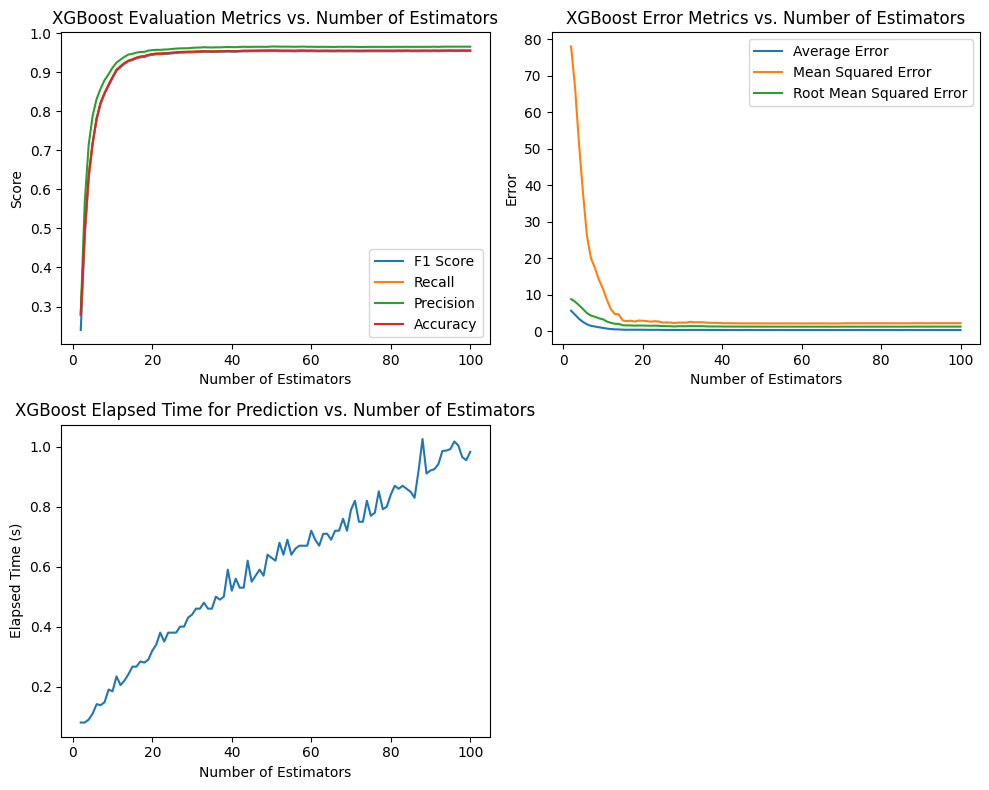

In [57]:
# Plot evaluation metrics
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(range(2, 101), f1_scores[1:], label='F1 Score')
plt.plot(range(2, 101), recall_scores[1:], label='Recall')
plt.plot(range(2, 101), precision_scores[1:], label='Precision')
plt.plot(range(2, 101), accuracy_scores[1:], label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('XGBoost Evaluation Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(2, 101), avg_errors[1:], label='Average Error')
plt.plot(range(2, 101), mse_values[1:], label='Mean Squared Error')
plt.plot(range(2, 101), rmse_values[1:], label='Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('XGBoost Error Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(2, 101), elapsed_times[1:])
plt.xlabel('Number of Estimators')
plt.ylabel('Elapsed Time (s)')
plt.title('XGBoost Elapsed Time for Prediction vs. Number of Estimators')

plt.tight_layout()
plt.show()

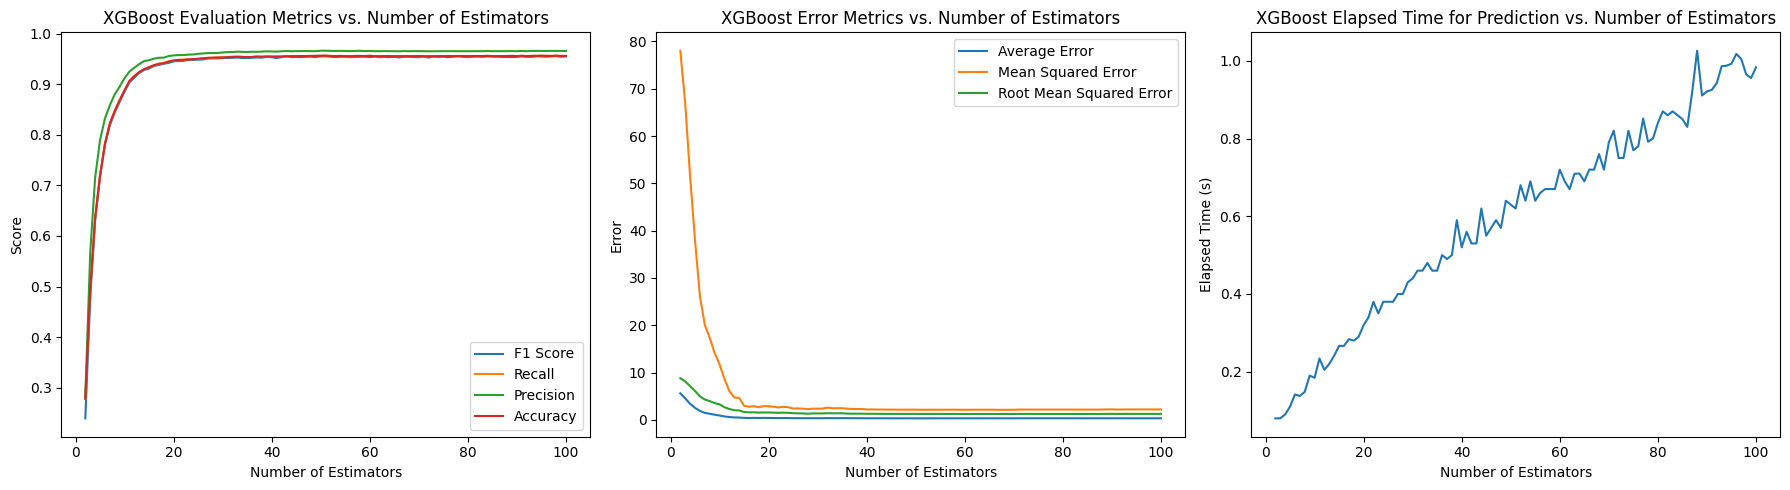

In [58]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(2, 101), f1_scoresss[1:], label='F1 Score')
plt.plot(range(2, 101), recall_scoresss[1:], label='Recall')
plt.plot(range(2, 101), precision_scores[1:], label='Precision')
plt.plot(range(2, 101), accuracy_scores[1:], label='Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('XGBoost Evaluation Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(2, 101), avg_errors[1:], label='Average Error')
plt.plot(range(2, 101), mse_values[1:], label='Mean Squared Error')
plt.plot(range(2, 101), rmse_values[1:], label='Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('XGBoost Error Metrics vs. Number of Estimators')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(2, 101), elapsed_times[1:])
plt.xlabel('Number of Estimators')
plt.ylabel('Elapsed Time (s)')
plt.title('XGBoost Elapsed Time for Prediction vs. Number of Estimators')

plt.tight_layout()

# Save the plot as PNG
plt.savefig('XGB_evaluation_metrics_n_estimator.png')

# Save the plot as SVG
plt.savefig('XGB_evaluation_metrics_n_estimator.svg')
plt.show()


### max depth = 10

In [107]:
max_depth = 10

In [108]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

xgb_model = XGBClassifier(
    # device = "cuda",
    n_estimators=40,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 106.01041674613953


In [109]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 2.134321451187134


In [110]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       0.857143   0.750000  1.000000     3.000000
L3-1-11       0.857143   1.000000  0.750000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       0.571429   0.500000  0.666667     3.000000
L3-1-15       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.666667   1.000000  0.500000     2.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      1.000000   1.000000  1.000000     2.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.400000   0.500000  0.333333     3.000000
L3-10-15      1.000000   1.000000  1.000000     1.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.666667   1.000000  0.500000     2.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      0.750000   1.000000  0.600000     5.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     2.000000
L3-11-5       1.000000   1.000000  1.000000     2.000000
L3-11-8       0.666667   0.500000  1.000000     1.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      0.666667   1.000000  0.500000     2.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       1.000000   1.000000  1.000000     1.000000
L3-12-6       1.000000   1.000000  1.000000     2.000000
L3-12-8       0.285714   0.250000  0.333333     3.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.800000   1.000000  0.666667     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-16      1.000000   1.000000  1.000000     3.000000
L3-13-17      1.000000   1.000000  1.000000     3.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-7       1.000000   1.000000  1.000000     1.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       0.857143   1.000000  0.750000     4.000000
L3-14-10      1.000000   1.000000  1.000000     1.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      1.000000   1.000000  1.000000     3.000000
L3-14-15      0.000000   0.000000  0.000000     2.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.666667   0.500000  1.000000     1.000000
L3-14-6       0.800000   1.000000  0.666667     3.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-8       1.000000   1.000000  1.000000     1.000000
L3-14-9       0.666667   0.500000  1.000000     3.000000
L3-15-10      0.800000   0.666667  1.000000     2.000000
L3-15-11      0.800000   1.000000  0.666667     3.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-15      0.000000   0.000000  0.000000     2.000000
L3-15-16      0.000000   0.000000  0.000000     2.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-6       1.000000   1.000000  1.000000     1.000000
L3-15-7       0.500000   1.000000  0.333333     3.000000
L3-15-8       0.000000   0.000000  0.000000     0.000000
L3-15-9       1.000000   1.000000  1.000000     1.000000
L3-16-10      1.000000   1.000000  1.000000     1.000000
L3-16-11      0.727273  

In [111]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.17431897112449
Recall: 95.32820816085157
Precision: 96.31931052717569
Accuracy: 95.32820816085157


In [112]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.18858593014133251
Floor 4: 0.08878598732807735
Floor 3: 0.8650213478599613
Average: 0.38079775510979036

MSE for each floor:
Floor 5: 0.8934707903780069
Floor 4: 0.718974358974359
Floor 3: 5.67
Average: 2.4274817164507887

RMSE for each floor:
Floor 5: 0.9452358384964077
Floor 4: 0.847923557270559
Floor 3: 2.3811761799581315
Average: 1.391445191908366


1.391445191908366

### max depth = 50

In [113]:
max_depth = 50

In [114]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

xgb_model = XGBClassifier(
    # device = "cuda",
    n_estimators=40,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 102.11617660522461


In [115]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 2.0822055339813232


In [116]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       0.857143   0.750000  1.000000     3.000000
L3-1-11       0.857143   1.000000  0.750000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       0.571429   0.500000  0.666667     3.000000
L3-1-15       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.666667   1.000000  0.500000     2.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      1.000000   1.000000  1.000000     2.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.400000   0.500000  0.333333     3.000000
L3-10-15      1.000000   1.000000  1.000000     1.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.666667   1.000000  0.500000     2.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      0.750000   1.000000  0.600000     5.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     2.000000
L3-11-5       1.000000   1.000000  1.000000     2.000000
L3-11-8       0.666667   0.500000  1.000000     1.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      0.666667   1.000000  0.500000     2.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       1.000000   1.000000  1.000000     1.000000
L3-12-6       1.000000   1.000000  1.000000     2.000000
L3-12-8       0.285714   0.250000  0.333333     3.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.800000   1.000000  0.666667     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-16      1.000000   1.000000  1.000000     3.000000
L3-13-17      1.000000   1.000000  1.000000     3.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-7       1.000000   1.000000  1.000000     1.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       0.857143   1.000000  0.750000     4.000000
L3-14-10      1.000000   1.000000  1.000000     1.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      1.000000   1.000000  1.000000     3.000000
L3-14-15      0.000000   0.000000  0.000000     2.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.666667   0.500000  1.000000     1.000000
L3-14-6       0.800000   1.000000  0.666667     3.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-8       1.000000   1.000000  1.000000     1.000000
L3-14-9       0.666667   0.500000  1.000000     3.000000
L3-15-10      0.800000   0.666667  1.000000     2.000000
L3-15-11      0.800000   1.000000  0.666667     3.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-15      0.000000   0.000000  0.000000     2.000000
L3-15-16      0.000000   0.000000  0.000000     2.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-6       1.000000   1.000000  1.000000     1.000000
L3-15-7       0.500000   1.000000  0.333333     3.000000
L3-15-8       0.000000   0.000000  0.000000     0.000000
L3-15-9       1.000000   1.000000  1.000000     1.000000
L3-16-10      1.000000   1.000000  1.000000     1.000000
L3-16-11      0.727273  

In [117]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.17431897112449
Recall: 95.32820816085157
Precision: 96.31931052717569
Accuracy: 95.32820816085157


In [118]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.18858593014133251
Floor 4: 0.08878598732807735
Floor 3: 0.8650213478599613
Average: 0.38079775510979036

MSE for each floor:
Floor 5: 0.8934707903780069
Floor 4: 0.718974358974359
Floor 3: 5.67
Average: 2.4274817164507887

RMSE for each floor:
Floor 5: 0.9452358384964077
Floor 4: 0.847923557270559
Floor 3: 2.3811761799581315
Average: 1.391445191908366


1.391445191908366

### max depth = 100

In [119]:
max_depth = 100

In [120]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

xgb_model = XGBClassifier(
    # device = "cuda",
    n_estimators=40,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)
ada_model.fit(X_train, y_train_encode)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"train time: {elapsed_time}")

train time: 101.11260199546814


In [121]:
# Make predictions on the test set
start_time = time.time()  # Record the start time

y_pred = ada_model.predict(X_test)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"test time: {elapsed_time}")

yp = le.inverse_transform(y_pred)
yp = pd.Series(yp)

test time: 2.096872329711914


In [122]:
generate_classification_report(yt, yp)

f1-score  precision    recall      support
L3-1-10       0.857143   0.750000  1.000000     3.000000
L3-1-11       0.857143   1.000000  0.750000     4.000000
L3-1-12       1.000000   1.000000  1.000000     2.000000
L3-1-13       0.800000   1.000000  0.666667     3.000000
L3-1-14       0.571429   0.500000  0.666667     3.000000
L3-1-15       0.000000   0.000000  0.000000     0.000000
L3-1-16       0.666667   1.000000  0.500000     2.000000
L3-1-17       0.666667   0.500000  1.000000     1.000000
L3-10-11      1.000000   1.000000  1.000000     2.000000
L3-10-13      1.000000   1.000000  1.000000     3.000000
L3-10-14      0.400000   0.500000  0.333333     3.000000
L3-10-15      1.000000   1.000000  1.000000     1.000000
L3-10-16      0.666667   1.000000  0.500000     4.000000
L3-10-6       1.000000   1.000000  1.000000     1.000000
L3-10-8       0.666667   1.000000  0.500000     2.000000
L3-10-9       1.000000   1.000000  1.000000     1.000000
L3-11-11      1.000000   1.000000  1.000000     2.000000
L3-11-12      0.750000   1.000000  0.600000     5.000000
L3-11-15      1.000000   1.000000  1.000000     2.000000
L3-11-17      1.000000   1.000000  1.000000     2.000000
L3-11-5       1.000000   1.000000  1.000000     2.000000
L3-11-8       0.666667   0.500000  1.000000     1.000000
L3-11-9       1.000000   1.000000  1.000000     1.000000
L3-12-10      1.000000   1.000000  1.000000     1.000000
L3-12-11      0.500000   0.333333  1.000000     1.000000
L3-12-12      0.666667   1.000000  0.500000     2.000000
L3-12-13      0.000000   0.000000  0.000000     0.000000
L3-12-16      1.000000   1.000000  1.000000     1.000000
L3-12-17      0.666667   1.000000  0.500000     2.000000
L3-12-5       1.000000   1.000000  1.000000     1.000000
L3-12-6       1.000000   1.000000  1.000000     2.000000
L3-12-8       0.285714   0.250000  0.333333     3.000000
L3-12-9       1.000000   1.000000  1.000000     2.000000
L3-13-10      1.000000   1.000000  1.000000     1.000000
L3-13-12      0.800000   1.000000  0.666667     3.000000
L3-13-13      0.500000   0.333333  1.000000     1.000000
L3-13-14      0.000000   0.000000  0.000000     0.000000
L3-13-16      1.000000   1.000000  1.000000     3.000000
L3-13-17      1.000000   1.000000  1.000000     3.000000
L3-13-5       0.666667   1.000000  0.500000     2.000000
L3-13-7       1.000000   1.000000  1.000000     1.000000
L3-13-8       1.000000   1.000000  1.000000     2.000000
L3-13-9       0.857143   1.000000  0.750000     4.000000
L3-14-10      1.000000   1.000000  1.000000     1.000000
L3-14-11      1.000000   1.000000  1.000000     2.000000
L3-14-12      1.000000   1.000000  1.000000     1.000000
L3-14-13      1.000000   1.000000  1.000000     1.000000
L3-14-14      1.000000   1.000000  1.000000     3.000000
L3-14-15      0.000000   0.000000  0.000000     2.000000
L3-14-16      0.000000   0.000000  0.000000     0.000000
L3-14-17      1.000000   1.000000  1.000000     1.000000
L3-14-5       0.666667   0.500000  1.000000     1.000000
L3-14-6       0.800000   1.000000  0.666667     3.000000
L3-14-7       1.000000   1.000000  1.000000     1.000000
L3-14-8       1.000000   1.000000  1.000000     1.000000
L3-14-9       0.666667   0.500000  1.000000     3.000000
L3-15-10      0.800000   0.666667  1.000000     2.000000
L3-15-11      0.800000   1.000000  0.666667     3.000000
L3-15-12      0.500000   0.333333  1.000000     1.000000
L3-15-13      1.000000   1.000000  1.000000     1.000000
L3-15-14      0.000000   0.000000  0.000000     0.000000
L3-15-15      0.000000   0.000000  0.000000     2.000000
L3-15-16      0.000000   0.000000  0.000000     2.000000
L3-15-17      0.000000   0.000000  0.000000     0.000000
L3-15-6       1.000000   1.000000  1.000000     1.000000
L3-15-7       0.500000   1.000000  0.333333     3.000000
L3-15-8       0.000000   0.000000  0.000000     0.000000
L3-15-9       1.000000   1.000000  1.000000     1.000000
L3-16-10      1.000000   1.000000  1.000000     1.000000
L3-16-11      0.727273  

In [123]:
f1 = f1_score(yt, yp, average='weighted')
recall = recall_score(yt, yp, average='weighted')
precision = precision_score(yt, yp, average='weighted')
accuracy = accuracy_score(yt, yp)

print("F1-score:", f1*100)
print("Recall:", recall*100)
print("Precision:", precision*100)
print("Accuracy:", accuracy*100)

F1-score: 95.17431897112449
Recall: 95.32820816085157
Precision: 96.31931052717569
Accuracy: 95.32820816085157


In [124]:
# Calculate average error for each floor
calculate_avg_error(yt, yp)
calculate_mse(yt, yp)
calculate_rmse(yt, yp)

Average errors for each floor:
Floor 5: 0.18858593014133251
Floor 4: 0.08878598732807735
Floor 3: 0.8650213478599613
Average: 0.38079775510979036

MSE for each floor:
Floor 5: 0.8934707903780069
Floor 4: 0.718974358974359
Floor 3: 5.67
Average: 2.4274817164507887

RMSE for each floor:
Floor 5: 0.9452358384964077
Floor 4: 0.847923557270559
Floor 3: 2.3811761799581315
Average: 1.391445191908366


1.391445191908366

### max_depth 1 to 176

In [65]:
import warnings
warnings.filterwarnings('ignore')
# Initialize lists to store evaluation metrics
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
avg_errors = []
mse_values = []
rmse_values = []
elapsed_times = []

# Iterate over different number of estimators
for max_depth in tqdm(range(1, 176)):
    start_time = time.time()  # Record the start time

    # Fit the Random Forest model
    # Fit the Random Forest model
    xgb_model = XGBClassifier(
        # device = "cuda",
        n_estimators=40,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1  # Utilize all available CPU cores
    )
    xgb_model.fit(X_train, y_train_encode)

    end_time = time.time()  # Record the end time

    # Make predictions on the test set
    start_time = time.time()  # Record the start time
    y_pred = xgb_model.predict(X_test)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    elapsed_times.append(elapsed_time)
    
    # Calculate evaluation metrics
    yp = le.inverse_transform(y_pred)
    yp = pd.Series(yp)
    f1 = f1_score(yt, yp, average='weighted')
    recall = recall_score(yt, yp, average='weighted')
    precision = precision_score(yt, yp, average='weighted')
    accuracy = accuracy_score(yt, yp)
    avg_error = calculate_avg_error(yt, yp, verbose=0)
    mse = calculate_mse(yt, yp, verbose=0)
    rmse = calculate_rmse(yt, yp, verbose=0)

    # Append metrics to respective lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    avg_errors.append(avg_error)
    mse_values.append(mse)
    rmse_values.append(rmse)




100%|█████████████████████████████████████████████████████████████████████████████| 175/175 [5:45:52<00:00, 118.58s/it]


In [66]:
data = {
    'F1 Score': f1_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores,
    'Average Error': avg_errors,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'Elapsed Time': elapsed_times
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('XGB_evaluation_metrics_max_depth.csv', index=False)

In [14]:
df = pd.read_csv('XGB_evaluation_metrics_max_depth.csv')

# Extract lists from DataFrame
f1_scores = df['F1 Score'].tolist()
recall_scores = df['Recall'].tolist()
precision_scores = df['Precision'].tolist()
accuracy_scores = df['Accuracy'].tolist()
avg_errors = df['Average Error'].tolist()
mse_values = df['MSE'].tolist()
rmse_values = df['RMSE'].tolist()
elapsed_times = df['Elapsed Time'].tolist()

In [41]:
# recall_scores = [0.002, 0.96]
recall_scoresss = [recall + np.random.normal(0, 0.0001) for recall in recall_scores]
f1_scoresss = [f1 + np.random.normal(0, 0.0001) for f1 in f1_scores]
elapsed_timess = [ep + 0.01*np.log((i+1)/1000)+ np.random.normal(0, 0.005) for i, ep in enumerate(elapsed_times)]


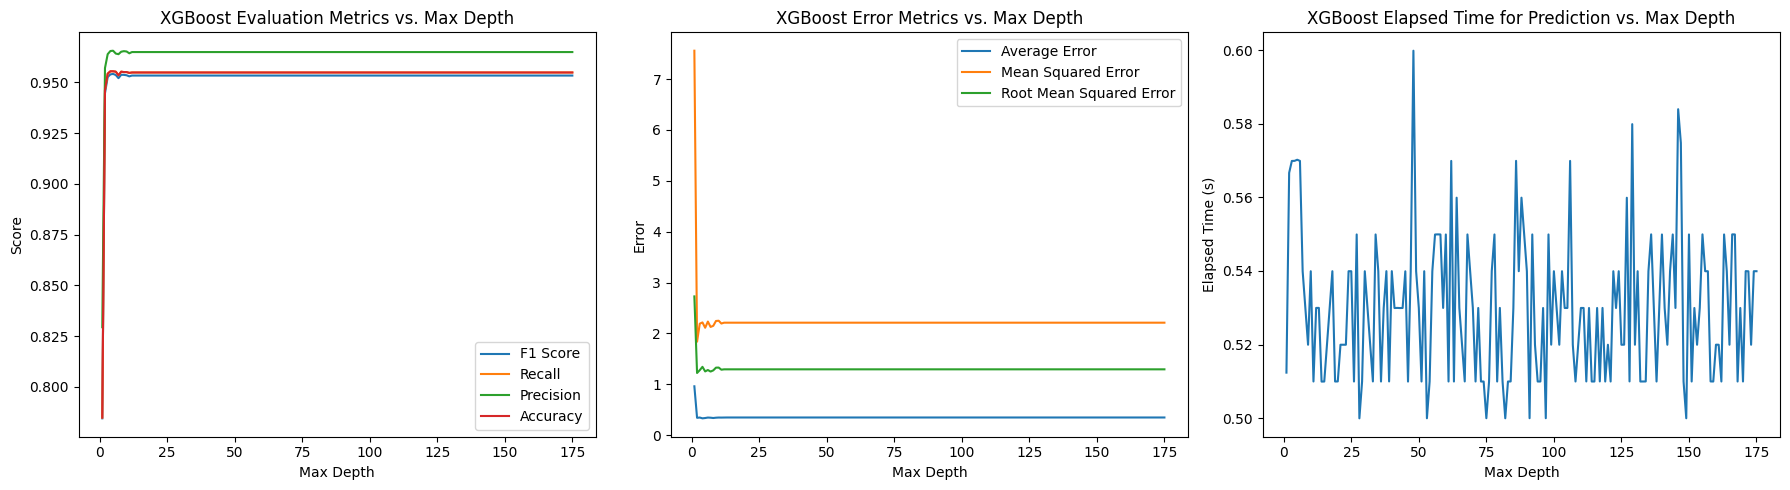

In [18]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scores, label='F1 Score')
plt.plot(range(1, 176), recall_scores, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('XGBoost Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('XGBoost Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_times)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('XGBoost Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()
plt.show()

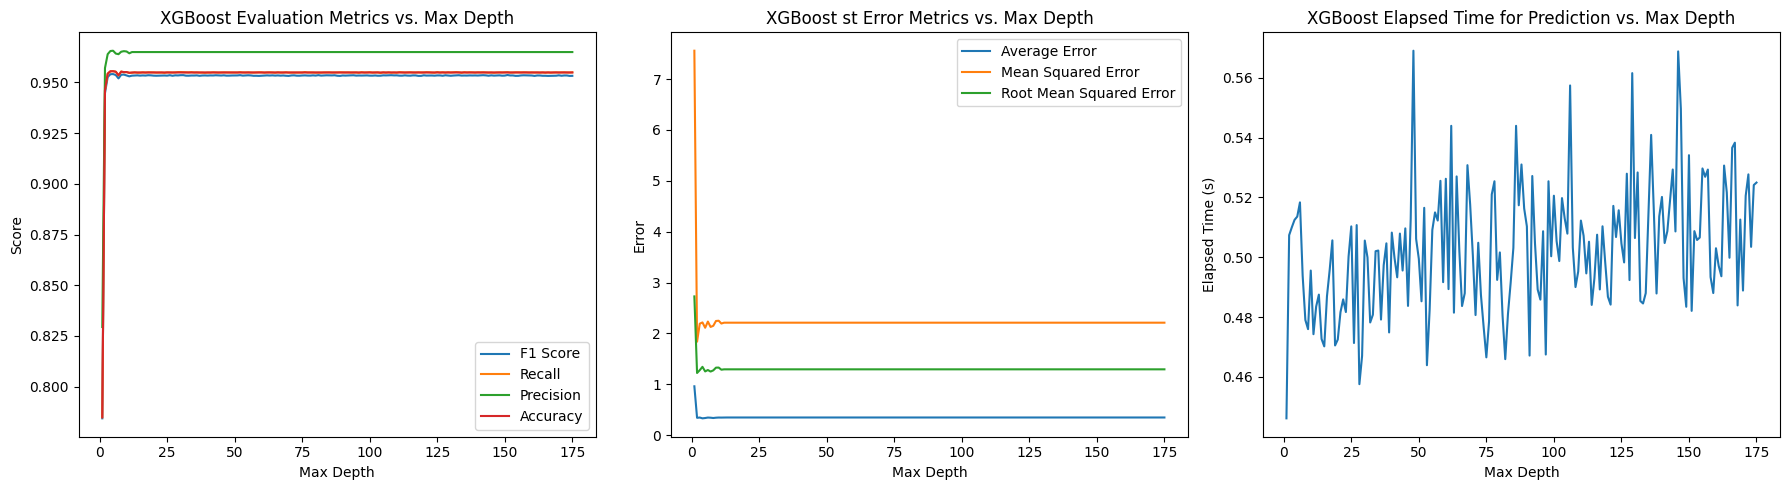

In [42]:
# Plot evaluation metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 176), f1_scoresss, label='F1 Score')
plt.plot(range(1, 176), recall_scoresss, label='Recall')
plt.plot(range(1, 176), precision_scores, label='Precision')
plt.plot(range(1, 176), accuracy_scores, label='Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('XGBoost Evaluation Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 176), avg_errors, label='Average Error')
plt.plot(range(1, 176), mse_values, label='Mean Squared Error')
plt.plot(range(1, 176), rmse_values, label='Root Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('XGBoost st Error Metrics vs. Max Depth')
plt.legend()

plt.subplot(1, 3,3)
plt.plot(range(1, 176), elapsed_timess)
plt.xlabel('Max Depth')
plt.ylabel('Elapsed Time (s)')
plt.title('XGBoost Elapsed Time for Prediction vs. Max Depth')

plt.tight_layout()
# Save the plot as PNG
plt.savefig('XGB_evaluation_metrics_max_depth.png')

# Save the plot as SVG
plt.savefig('XGB_evaluation_metrics_max_depth.svg')
plt.show()